In [1]:
from collections import OrderedDict
from glob import glob
import numpy as np
import pandas as pd
from os.path import join
import re
from sklearn.model_selection import train_test_split
import xarray as xr

import torch
import torch.nn as nn
from torch import Tensor
from torchmetrics.utilities.checks import _check_same_shape
from torchmetrics import Metric
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

from pismemulator.metrics import AbsoluteError, absolute_error


/home/andy/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PDDEmulator(pl.LightningModule):
    def __init__(
        self,
        n_parameters: int,
        n_outputs: int,
        hparams,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters(hparams)
        n_layers = self.hparams.n_layers
        n_hidden = self.hparams.n_hidden

        if isinstance(n_hidden, int):
            n_hidden = [n_hidden] * (n_layers - 1)

        # Inputs to hidden layer linear transformation
        self.l_first = nn.Linear(n_parameters, n_hidden[0])
        self.norm_first = nn.LayerNorm(n_hidden[0])
        self.dropout_first = nn.Dropout(p=0.0)

        models = []
        for n in range(n_layers - 2):
            models.append(
                nn.Sequential(
                    OrderedDict(
                        [
                            ("Linear", nn.Linear(n_hidden[n], n_hidden[n + 1])),
                            ("LayerNorm", nn.LayerNorm(n_hidden[n + 1])),
                            ("Dropout", nn.Dropout(p=0.1)),
                        ]
                    )
                )
            )
        self.dnn = nn.ModuleList(models)
        self.l_last = nn.Linear(n_hidden[-1], n_outputs)

        self.train_ae = AbsoluteError()
        self.test_ae = AbsoluteError()

    def forward(self, x, add_mean=False):
        # Pass the input tensor through each of our operations

        a = self.l_first(x)
        a = self.norm_first(a)
        a = self.dropout_first(a)
        z = torch.relu(a)

        for dnn in self.dnn:
            a = dnn(z)
            z = torch.relu(a) + z

        return self.l_last(z)


    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = parent_parser.add_argument_group("NNEmulator")
        parser.add_argument("--batch_size", type=int, default=128)
        parser.add_argument("--n_hidden", default=128)
        parser.add_argument("--learning_rate", type=float, default=0.1)

        return parent_parser

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), self.hparams.learning_rate, weight_decay=0.0
        )
        # This is an approximation to Doug's version:
        scheduler = {
            "scheduler": ExponentialLR(optimizer, 0.9975, verbose=True),
        }

        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, f, o, _ = batch
        f_pred = self.forward(x)
        loss = absolute_error(f_pred, f, o)

        return loss

    def validation_step(self, batch, batch_idx):
        x, f, o, o_0 = batch
        f_pred = self.forward(x)

        self.log("train_loss", self.train_ae(f_pred, f, o))
        self.log("test_loss", self.test_ae(f_pred, f, o_0))

        return {"x": x, "f": f, "f_pred": f_pred, "o": o, "o_0": o_0}

    def validation_epoch_end(self, outputs):

        self.log(
            "train_loss",
            self.train_ae,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "test_loss",
            self.test_ae,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )


In [3]:
class TorchPDDModel(torch.nn.modules.Module):
    """

    # Copyright (c) 2013--2018, Julien Seguinot <seguinot@vaw.baug.ethz.ch>
    # GNU General Public License v3.0+ (https://www.gnu.org/licenses/gpl-3.0.txt)

    A positive degree day model for glacier surface mass balance

    Return a callable Positive Degree Day (PDD) model instance.

    Model parameters are held as public attributes, and can be set using
    corresponding keyword arguments at initialization time:

    *pdd_factor_snow* : float
        Positive degree-day factor for snow.
    *pdd_factor_ice* : float
        Positive degree-day factor for ice.
    *refreeze_snow* : float
        Refreezing fraction of melted snow.
    *refreeze_ice* : float
        Refreezing fraction of melted ice.
    *temp_snow* : float
        Temperature at which all precipitation falls as snow.
    *temp_rain* : float
        Temperature at which all precipitation falls as rain.
    *interpolate_rule* : [ 'linear' | 'nearest' | 'zero' |
                           'slinear' | 'quadratic' | 'cubic' ]
        Interpolation rule passed to `scipy.interpolate.interp1d`.
    *interpolate_n*: int
        Number of points used in interpolations.
    """

    def __init__(
        self,
        pdd_factor_snow=3,
        pdd_factor_ice=8,
        refreeze_snow=0.0,
        refreeze_ice=0.0,
        temp_snow=0.0,
        temp_rain=2.0,
        interpolate_rule="linear",
        interpolate_n=52,
        *args,
        **kwargs,
    ):
        super().__init__()

        # set pdd model parameters
        self.pdd_factor_snow = pdd_factor_snow
        self.pdd_factor_ice = pdd_factor_ice
        self.refreeze_snow = refreeze_snow
        self.refreeze_ice = refreeze_ice
        self.temp_snow = temp_snow
        self.temp_rain = temp_rain
        self.interpolate_rule = interpolate_rule
        self.interpolate_n = interpolate_n

    def forward(self, temp, prec, stdv=0.0):
        """Run the positive degree day model.

        Use temperature, precipitation, and standard deviation of temperature
        to compute the number of positive degree days, accumulation and melt
        surface mass fluxes, and the resulting surface mass balance.

        *temp*: array_like
            Input near-surface air temperature in degrees Celcius.
        *prec*: array_like
            Input precipitation rate in meter per year.
        *stdv*: array_like (default 0.0)
            Input standard deviation of near-surface air temperature in Kelvin.

        By default, inputs are N-dimensional arrays whose first dimension is
        interpreted as time and as periodic. Arrays of dimensions
        N-1 are interpreted as constant in time and expanded to N dimensions.
        Arrays of dimension 0 and numbers are interpreted as constant in time
        and space and will be expanded too. The largest input array determines
        the number of dimensions N.

        Return the number of positive degree days ('pdd'), surface mass balance
        ('smb'), and many other output variables in a dictionary.
        """

        # ensure numpy arrays
        temp = torch.asarray(temp)
        prec = torch.asarray(prec)
        stdv = torch.asarray(stdv)

        # expand arrays to the largest shape
        maxshape = max(temp.shape, prec.shape, stdv.shape)
        temp = self._expand(temp, maxshape)
        prec = self._expand(prec, maxshape)
        stdv = self._expand(stdv, maxshape)

        # interpolate time-series
        if self.interpolate_n >= 1:
            temp = self._interpolate(temp)
            prec = self._interpolate(prec)
            stdv = self._interpolate(stdv)

        # compute accumulation and pdd
        accu_rate = self.accu_rate(temp, prec)
        inst_pdd = self.inst_pdd(temp, stdv)

        # initialize snow depth, melt and refreeze rates
        snow_depth = torch.zeros_like(temp)
        snow_melt_rate = torch.zeros_like(temp)
        ice_melt_rate = torch.zeros_like(temp)
        snow_refreeze_rate = torch.zeros_like(temp)
        ice_refreeze_rate = torch.zeros_like(temp)

        snow_depth[:-1] = torch.clone(snow_depth[1:])
        snow_depth = snow_depth + accu_rate
        snow_melt_rate, ice_melt_rate = self.melt_rates(snow_depth, inst_pdd)
        snow_depth = snow_depth - snow_melt_rate

        melt_rate = snow_melt_rate + ice_melt_rate
        snow_refreeze_rate = self.refreeze_snow * snow_melt_rate
        ice_refreeze_rate = self.refreeze_ice * ice_melt_rate
        refreeze_rate = snow_refreeze_rate + ice_refreeze_rate
        runoff_rate = melt_rate - refreeze_rate
        inst_smb = accu_rate - runoff_rate

        # output
        return {
            "temp": temp,
            "prec": prec,
            "stdv": stdv,
            "inst_pdd": inst_pdd,
            "accu_rate": accu_rate,
            "snow_melt_rate": snow_melt_rate,
            "ice_melt_rate": ice_melt_rate,
            "melt_rate": melt_rate,
            "snow_refreeze_rate": snow_refreeze_rate,
            "ice_refreeze_rate": ice_refreeze_rate,
            "refreeze_rate": refreeze_rate,
            "runoff_rate": runoff_rate,
            "inst_smb": inst_smb,
            "snow_depth": snow_depth,
            "pdd": self._integrate(inst_pdd),
            "accu": self._integrate(accu_rate),
            "snow_melt": self._integrate(snow_melt_rate),
            "ice_melt": self._integrate(ice_melt_rate),
            "melt": self._integrate(melt_rate),
            "runoff": self._integrate(runoff_rate),
            "refreeze": self._integrate(refreeze_rate),
            "smb": self._integrate(inst_smb),
        }

    def _expand(self, array, shape):
        """Expand an array to the given shape"""
        if array.shape == shape:
            res = array
        elif array.shape == (1, shape[1], shape[2]):
            res = np.asarray([array[0]] * shape[0])
        elif array.shape == shape[1:]:
            res = np.asarray([array] * shape[0])
        elif array.shape == ():
            res = array * torch.ones(shape)
        else:
            raise ValueError(
                "could not expand array of shape %s to %s" % (array.shape, shape)
            )
        return res

    def _integrate(self, array):
        """Integrate an array over one year"""
        return torch.sum(array, axis=0) / (self.interpolate_n - 1)

    def _interpolate(self, array):
        """Interpolate an array through one year."""

        from scipy.interpolate import interp1d

        rule = self.interpolate_rule
        npts = self.interpolate_n
        oldx = (torch.arange(len(array) + 2) - 0.5) / len(array)
        oldy = torch.vstack((array[-1], array, array[0]))
        newx = (torch.arange(npts) + 0.5) / npts  # use 0.0 for PISM-like behaviour
        newy = interp1d(oldx, oldy, kind=rule, axis=0)(newx)

        return torch.from_numpy(newy)

    def inst_pdd(self, temp, stdv):
        """Compute instantaneous positive degree days from temperature.

        Use near-surface air temperature and standard deviation to compute
        instantaneous positive degree days (effective temperature for melt,
        unit degrees C) using an integral formulation (Calov and Greve, 2005).

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        *stdv*: array_like
            Standard deviation of near-surface air temperature in Kelvin.
        """

        # compute positive part of temperature everywhere
        positivepart = torch.greater(temp, 0) * temp

        # compute Calov and Greve (2005) integrand, ignoring division by zero
        normtemp = temp / (torch.sqrt(torch.tensor(2)) * stdv)
        calovgreve = stdv / torch.sqrt(torch.tensor(2) * torch.pi) * torch.exp(
            -(normtemp**2)
        ) + temp / 2 * torch.erfc(-normtemp)

        # use positive part where sigma is zero and Calov and Greve elsewhere
        teff = torch.where(stdv == 0.0, positivepart, calovgreve)

        # convert to degree-days
        return teff * 365.242198781

    def accu_rate(self, temp, prec):
        """Compute accumulation rate from temperature and precipitation.

        The fraction of precipitation that falls as snow decreases linearly
        from one to zero between temperature thresholds defined by the
        `temp_snow` and `temp_rain` attributes.

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        *prec*: array_like
            Precipitation rate in meter per year.
        """

        # compute snow fraction as a function of temperature
        reduced_temp = (self.temp_rain - temp) / (self.temp_rain - self.temp_snow)
        snowfrac = torch.clip(reduced_temp, 0, 1)

        # return accumulation rate
        return snowfrac * prec

    def melt_rates(self, snow, pdd):
        """Compute melt rates from snow precipitation and pdd sum.

        Snow melt is computed from the number of positive degree days (*pdd*)
        and the `pdd_factor_snow` model attribute. If all snow is melted and
        some energy (PDD) remains, ice melt is computed using `pdd_factor_ice`.

        *snow*: array_like
            Snow precipitation rate.
        *pdd*: array_like
            Number of positive degree days.
        """

        # parse model parameters for readability
        ddf_snow = self.pdd_factor_snow / 1e3
        ddf_ice = self.pdd_factor_ice / 1e3

        # compute a potential snow melt
        pot_snow_melt = ddf_snow * pdd

        # effective snow melt can't exceed amount of snow
        snow_melt = torch.minimum(snow, pot_snow_melt)

        # ice melt is proportional to excess snow melt
        ice_melt = (pot_snow_melt - snow_melt) * ddf_ice / ddf_snow

        # return melt rates
        return (snow_melt, ice_melt)

In [44]:
def read_observation(file="DMI-HIRHAM5_1980_MM.nc", thinning_factor=1):
    """
    Read and return Obs
    """

    with xr.open_dataset(file) as Obs:

        stacked = Obs.stack(z=("rlat", "rlon"))
        ncl_stacked = Obs.stack(z=("ncl4", "ncl5"))

        temp = stacked.tas.dropna(dim="z").values
        rainfall = stacked.rainfall.dropna(dim="z").values / 1000
        snowfall = stacked.snfall.dropna(dim="z").values / 1000
        smb = stacked.gld.dropna(dim="z").values / 1000
        refreeze = ncl_stacked.rfrz.dropna(dim="z").values / 1000
        melt = stacked.snmel.dropna(dim="z").values / 1000
        precip = rainfall + snowfall

    return (
        temp[..., ::thinning_factor] - 273.15,
        precip[..., ::thinning_factor],
        refreeze.sum(axis=0)[..., ::thinning_factor],
        snowfall.sum(axis=0)[..., ::thinning_factor],
        melt.sum(axis=0)[..., ::thinning_factor],
        smb.sum(axis=0)[..., ::thinning_factor],
    )



In [56]:
temp, precip, _, _, _, _ = read_observation(thinning_factor=100)
std_dev = np.zeros_like(temp) + 4

In [57]:
from SALib.sample import saltelli
from pyDOE import lhs
from scipy.stats.distributions import truncnorm, gamma, uniform, randint
method = "lhs"
n_prior_samples = 250
np.random.seed(2)

distributions = {
    "f_snow": uniform(
        loc=2.0, scale=4.0
    ),  # uniform between 2 and 6
    "f_ice": uniform(
        loc=3.0, scale=9
    ),  # uniform between 3 and 12
    "refreeze": uniform(loc=0, scale=1.0),  # uniform between 0 and 1
}
# Names of all the variables
keys = [x for x in distributions.keys()]

# Describe the Problem
problem = {"num_vars": len(keys), "names": keys, "bounds": [[0, 1]] * len(keys)}

# Generate uniform samples (i.e. one unit hypercube)
if method == "saltelli":
    unif_sample = saltelli.sample(problem, n_prior_samples, calc_second_order=False)
elif method == "lhs":
    unif_sample = lhs(len(keys), n_prior_samples)
else:
    print(f"Method {method} not available")

# To hold the transformed variables
dist_sample = np.zeros_like(unif_sample)

# Now transform the unit hypercube to the prescribed distributions
# For each variable, transform with the inverse of the CDF (inv(CDF)=ppf)
for i, key in enumerate(keys):
    dist_sample[:, i] = distributions[key].ppf(unif_sample[:, i])

# Save to CSV file using Pandas DataFrame and to_csv method
header = keys
# Convert to Pandas dataframe, append column headers, output as csv
df = pd.DataFrame(data=dist_sample, columns=header)

In [58]:
    X = []
    Y = []
    for k, row in df.iterrows():   
        m_f_snow = row["f_snow"]
        m_f_ice = row["f_ice"]
        m_refreeze = row["refreeze"]

        pdd = TorchPDDModel(
            pdd_factor_snow=m_f_snow,
            pdd_factor_ice=m_f_ice,
            refreeze_snow=m_refreeze,
            refreeze_ice=m_refreeze,
        )
        result = pdd(temp, precip, std_dev)

        M_train = result["melt"]
        A_train = result["accu"]
        R_train = result["refreeze"]
        m_Y = torch.vstack((M_train, A_train, R_train,)).T
        Y.append(m_Y)
        X.append(torch.from_numpy(np.hstack((temp.T, precip.T, np.tile(m_f_snow, (temp.shape[1], 1)), np.tile(m_f_ice, (temp.shape[1], 1)), np.tile(m_refreeze, (temp.shape[1], 1))))))

    X_train = torch.vstack(X).type(torch.FloatTensor)
    Y_train = torch.vstack(Y).type(torch.FloatTensor)
    n_samples, n_parameters = X_train.shape
    n_outputs = Y_train.shape[1]


In [59]:
n_samples

166000

In [60]:
# Normalize
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train_norm = (X_train - X_train_mean) / X_train_std


In [61]:
X_train.shape

torch.Size([166000, 27])

In [62]:
print(X_train.shape, X_train_mean.shape)

torch.Size([166000, 27]) torch.Size([27])


In [63]:
    import os
    from scipy.stats import dirichlet

    model_index = 0
    torch.manual_seed(0)
    pl.seed_everything(0)
    np.random.seed(model_index)
    emulator_dir = "pddemulator"

    if not os.path.isdir(emulator_dir):
        os.makedirs(emulator_dir)
        os.makedirs(os.path.join(emulator_dir, "emulator"))


Global seed set to 0


In [64]:
# Copyright (C) 2021 Andy Aschwanden, Douglas C Brinkerhoff
#
# This file is part of pism-emulator.
#
# PISM-EMULATOR is free software; you can redistribute it and/or modify it under the
# terms of the GNU General Public License as published by the Free Software
# Foundation; either version 3 of the License, or (at your option) any later
# version.
#
# PISM-EMULATOR is distributed in the hope that it will be useful, but WITHOUT ANY
# WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more
# details.
#
# You should have received a copy of the GNU General Public License
# along with PISM; if not, write to the Free Software
# Foundation, Inc., 51 Franklin St, Fifth Floor, Boston, MA  02110-1301  USA

import torch
from torch import Tensor
from torchmetrics.utilities.checks import _check_same_shape
from torchmetrics import Metric


def _absolute_error_update(
    preds: Tensor, target: Tensor, omegas: Tensor) -> Tensor:
    _check_same_shape(preds, target)
    diff = torch.abs(preds - target)
    sum_abs_error = torch.sum(diff * diff, axis=1)
    absolute_error = torch.sum(sum_abs_error * omegas.squeeze())
    return absolute_error


def _absolute_error_compute(absolute_error) -> Tensor:
    return absolute_error


def absolute_error(
    preds: Tensor, target: Tensor, omegas: Tensor
) -> Tensor:
    """
    Computes squared absolute error
    Args:
        preds: estimated labels
        target: ground truth labels
        omegas: weights
        area: area of each cell
    Return:
        Tensor with absolute error
    Example:
        >>> x = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]]).T
        >>> y = torch.tensor([[0, 1, 2, 1], [2, 3, 4, 4]]).T
        >>> o = torch.tensor([0.25, 0.25, 0.3, 0.2])
        >>> a = torch.tensor([0.25, 0.25])
        >>> absolute_error(x, y, o, a)
        tensor(0.4000)
    """
    sum_abs_error = _absolute_error_update(preds, target, omegas)
    return _absolute_error_compute(sum_abs_error)


class AbsoluteError(Metric):
    def __init__(self, compute_on_step: bool = True, dist_sync_on_step=False):
        # call `self.add_state`for every internal state that is needed for the metrics computations
        # dist_reduce_fx indicates the function that should be used to reduce
        # state from multiple processes
        super().__init__(
            compute_on_step=compute_on_step, dist_sync_on_step=dist_sync_on_step
        )

        self.add_state("sum_abs_error", default=torch.tensor(0.0), dist_reduce_fx="sum")

    def update(self, preds: Tensor, target: Tensor, omegas: Tensor):
        """
        Update state with predictions and targets, and area.
        Args:
            preds: Predictions from model
            target: Ground truth values
            omegas: Weights
            area: Area of each cell
        """
        sum_abs_error = _absolute_error_update(preds, target, omegas)
        self.sum_abs_error += sum_abs_error

    def compute(self):
        """
        Computes absolute error over state.
        """
        return _absolute_error_compute(self.sum_abs_error)

    @property
    def is_differentiable(self):
        return True


In [65]:
class PDDDataModule(pl.LightningDataModule):
    def __init__(
        self,
        X,
        Y,
        omegas,
        omegas_0,
        batch_size: int = 128,
        train_size: float = 0.9,
        num_workers: int = 0,
    ):
        super().__init__()
        self.X = X
        self.Y = Y
        self.omegas = omegas
        self.omegas_0 = omegas_0
        self.batch_size = batch_size
        self.train_size = train_size
        self.num_workers = num_workers

    def setup(self, stage: str = None):

        all_data = TensorDataset(self.X, self.Y, self.omegas, self.omegas_0)
        self.all_data = all_data

        training_data, val_data = train_test_split(
            all_data, train_size=self.train_size, random_state=0
        )
        self.training_data = training_data
        self.test_data = training_data

        self.val_data = val_data
        train_all_loader = DataLoader(
            dataset=all_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.train_all_loader = train_all_loader
        val_all_loader = DataLoader(
            dataset=all_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.val_all_loader = val_all_loader
        train_loader = DataLoader(
            dataset=training_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.train_loader = train_loader
        self.test_loader = train_loader
        val_loader = DataLoader(
            dataset=val_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )
        self.val_loader = val_loader

    def prepare_data(self, **kwargs):
        pass
    
    def train_dataloader(self):
        return self.train_loader

    def validation_dataloader(self):
        return self.val_loader


In [66]:
    print(f"Training model {model_index}")
    omegas = torch.Tensor(dirichlet.rvs(np.ones(n_samples))).T
    omegas = omegas.type(torch.FloatTensor)
    omegas_0 = torch.ones_like(omegas) / len(omegas)
    area = torch.ones_like(omegas)
    train_size = 1.0
    num_workers = 8
    hparams = {"n_layers": 5, "n_hidden": 128, "batch_size": 128, "learning_rate": 0.01}
    
    if train_size == 1.0:
        data_loader = PDDDataModule(X_train_norm, Y_train, omegas, omegas_0, num_workers=num_workers)
    else:
        data_loader = PDDDataModule(
            X_train_norm, Y_train, omegas, omegas_0, train_size=train_size, num_workers=num_workers
        )

    data_loader.setup()
    e = PDDEmulator(
        n_parameters,
        n_outputs,
        hparams,
    )
    trainer = pl.Trainer(
        auto_lr_find=True,
        max_epochs=100,
        gpus=1,
#        deterministic=True,
        num_sanity_val_steps=0,
    )
    if train_size == 1.0:
        train_loader = data_loader.train_all_loader
        val_loader = data_loader.val_all_loader
    else:
        train_loader = data_loader.train_loader
        val_loader = data_loader.val_loader

        
    # lr_finder = trainer.tuner.lr_find(e, train_loader, val_loader)
    # fig = lr_finder.plot(suggest=True) # Plot
    # fig.show()
    trainer.fit(e, train_loader, val_loader)
    torch.save(e.state_dict(), f"{emulator_dir}/emulator/emulator_{model_index}.h5")


Training model 0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | l_first       | Linear        | 3.6 K 
1 | norm_first    | LayerNorm     | 256   
2 | dropout_first | Dropout       | 0     
3 | dnn           | ModuleList    | 50.3 K
4 | l_last        | Linear        | 387   
5 | train_ae      | AbsoluteError | 0     
6 | test_ae       | AbsoluteError | 0     
------------------------------------------------
54.5 K    Trainable params
0         Non-trainable params
54.5 K    Total params
0.218     Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 0:  50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1297/2594 [00:06<00:06, 194.82it/s, loss=1.28e-05, v_num=32]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████████████████████████████████████████████████                                                      | 1297/2594 [00:06<00:06, 193.97it/s, loss=9.23e-06, v_num=32, train_loss=0.0112, test_loss=0.0115]
Validating: 0it [00:00, ?it/s]
Epoch 1:  55%|███████████████████████████████████████████████████████████▍                                                | 1428/2594 [00:07<00:05, 198.78it/s, loss=9.23e-06, v_num=32, train_loss=0.0112, test_loss=0.0115]


Epoch 2:  50%|██████████████████████████████████████████████████████▌                                                      | 1297/2594 [00:06<00:06, 194.87it/s, loss=6.01e-06, v_num=32, train_loss=0.011, test_loss=0.0114]
Validating: 0it [00:00, ?it/s]
Epoch 2:  67%|████████████████████████████████████████████████████████████████████████▊                                    | 1734/2594 [00:07<00:03, 223.32it/s, loss=6.01e-06, v_num=32, train_loss=0.011, test_loss=0.0114]


Epoch 3:  50%|█████████████████████████████████████████████████████▌                                                     | 1297/2594 [00:06<00:06, 194.29it/s, loss=2.4e-06, v_num=32, train_loss=0.00473, test_loss=0.00479]
Validating: 0it [00:00, ?it/s]
Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 2080/2594 [00:08<00:02, 245.24it/s, loss=2.4e-06, v_num=32, train_loss=0.00473, test_loss=0.00479]


Epoch 4:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:06<00:06, 192.92it/s, loss=5.11e-06, v_num=32, train_loss=0.00461, test_loss=0.00467]
Validating: 0it [00:00, ?it/s]
Epoch 4:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2444/2594 [00:09<00:00, 263.68it/s, loss=5.11e-06, v_num=32, train_loss=0.00461, test_loss=0.00467]


Epoch 5:  50%|█████████████████████████████████████████████████████▌                                                     | 1297/2594 [00:06<00:06, 194.42it/s, loss=3.53e-06, v_num=32, train_loss=0.0048, test_loss=0.00485]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:06<00:06, 193.54it/s, loss=4.21e-06, v_num=32, train_loss=0.00423, test_loss=0.00427]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                                                                                                                   | 0/1297 [00:00<?, ?it/s]


Epoch 7:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:06<00:06, 194.97it/s, loss=5.44e-06, v_num=32, train_loss=0.00673, test_loss=0.00681]
Validating: 0it [00:00, ?it/s]
Epoch 7:  62%|█████████████████████████████████████████████████████████████████▊                                        | 1612/2594 [00:07<00:04, 213.85it/s, loss=5.44e-06, v_num=32, train_loss=0.00673, test_loss=0.00681]


Epoch 8:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:07<00:07, 179.48it/s, loss=2.59e-06, v_num=32, train_loss=0.00492, test_loss=0.00502]
Validating: 0it [00:00, ?it/s]
Epoch 8:  76%|████████████████████████████████████████████████████████████████████████████████▋                         | 1976/2594 [00:09<00:02, 212.01it/s, loss=2.59e-06, v_num=32, train_loss=0.00492, test_loss=0.00502]


Epoch 9:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:07<00:07, 179.05it/s, loss=1.85e-06, v_num=32, train_loss=0.00304, test_loss=0.00305]
Validating: 0it [00:00, ?it/s]
Epoch 9:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▍            | 2288/2594 [00:10<00:01, 223.26it/s, loss=1.85e-06, v_num=32, train_loss=0.00304, test_loss=0.00305]


Epoch 10:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 192.42it/s, loss=2.26e-06, v_num=32, train_loss=0.00188, test_loss=0.00192]
Validating: 0it [00:00, ?it/s]
Epoch 11:  50%|████████████████████████████████████████████████████▍                                                    | 1296/2594 [00:06<00:06, 195.51it/s, loss=2.35e-06, v_num=32, train_loss=0.00287, test_loss=0.00288]Adjusting learning rate of group 0 to 9.7041e-03.


Epoch 11:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.83it/s, loss=2.08e-06, v_num=32, train_loss=0.00287, test_loss=0.00288]
Validating: 0it [00:00, ?it/s]
Epoch 12:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 194.25it/s, loss=1.16e-06, v_num=32, train_loss=0.00219, test_loss=0.00221]
Validating: 0it [00:00, ?it/s]
Epoch 12:  56%|██████████████████████████████████████████████████████████▉                                              | 1456/2594 [00:07<00:05, 201.21it/s, loss=1.16e-06, v_num=32, train_loss=0.00219, test_loss=0.00221]


Epoch 13:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:06<00:06, 193.11it/s, loss=1.47e-06, v_num=32, train_loss=0.0019, test_loss=0.00193]
Validating: 0it [00:00, ?it/s]
Epoch 13:  70%|██████████████████████████████████████████████████████████████████████████▎                               | 1820/2594 [00:08<00:03, 227.43it/s, loss=1.47e-06, v_num=32, train_loss=0.0019, test_loss=0.00193]


Epoch 14:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:06<00:06, 194.22it/s, loss=2.28e-06, v_num=32, train_loss=0.0023, test_loss=0.00232]
Validating: 0it [00:00, ?it/s]
Epoch 14:  84%|█████████████████████████████████████████████████████████████████████████████████████████▏                | 2184/2594 [00:08<00:01, 251.37it/s, loss=2.28e-06, v_num=32, train_loss=0.0023, test_loss=0.00232]


Epoch 15:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:06<00:06, 192.88it/s, loss=1.2e-06, v_num=32, train_loss=0.00238, test_loss=0.00246]
Validating: 0it [00:00, ?it/s]
Epoch 15:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2496/2594 [00:09<00:00, 265.83it/s, loss=1.2e-06, v_num=32, train_loss=0.00238, test_loss=0.00246]


Epoch 16:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 192.78it/s, loss=1.24e-06, v_num=32, train_loss=0.00122, test_loss=0.00124]
Validating: 0it [00:00, ?it/s]
Epoch 17:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 194.28it/s, loss=7.29e-07, v_num=32, train_loss=0.00145, test_loss=0.00148]
Validating: 0it [00:00, ?it/s]
Epoch 17:  52%|██████████████████████████████████████████████████████▋                                                  | 1352/2594 [00:07<00:06, 192.94it/s, loss=7.29e-07, v_num=32, train_loss=0.00145, test_loss=0.00148]


Epoch 18:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.51it/s, loss=9.87e-07, v_num=32, train_loss=0.000898, test_loss=0.000918]
Validating: 0it [00:00, ?it/s]
Epoch 18:  66%|████████████████████████████████████████████████████████████████████▏                                  | 1716/2594 [00:07<00:03, 220.81it/s, loss=9.87e-07, v_num=32, train_loss=0.000898, test_loss=0.000918]


Epoch 19:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:06<00:06, 193.41it/s, loss=8.5e-07, v_num=32, train_loss=0.00125, test_loss=0.00127]
Validating: 0it [00:00, ?it/s]
Epoch 19:  80%|████████████████████████████████████████████████████████████████████████████████████▉                     | 2080/2594 [00:08<00:02, 243.65it/s, loss=8.5e-07, v_num=32, train_loss=0.00125, test_loss=0.00127]


Epoch 20:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 194.19it/s, loss=6.93e-07, v_num=32, train_loss=0.00136, test_loss=0.00136]
Validating: 0it [00:00, ?it/s]
Epoch 20:  92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2392/2594 [00:09<00:00, 263.00it/s, loss=6.93e-07, v_num=32, train_loss=0.00136, test_loss=0.00136]


Epoch 21:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 194.01it/s, loss=1.47e-06, v_num=32, train_loss=0.000838, test_loss=0.000849]
Validating: 0it [00:00, ?it/s]
Epoch 22:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.21it/s, loss=1.03e-06, v_num=32, train_loss=0.00171, test_loss=0.00174]
Validating: 0it [00:00, ?it/s]


Epoch 23:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.43it/s, loss=7.86e-07, v_num=32, train_loss=0.00103, test_loss=0.00105]
Validating: 0it [00:00, ?it/s]
Epoch 23:  60%|███████████████████████████████████████████████████████████████▏                                         | 1560/2594 [00:07<00:04, 208.55it/s, loss=7.86e-07, v_num=32, train_loss=0.00103, test_loss=0.00105]


Epoch 24:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 193.31it/s, loss=2.79e-06, v_num=32, train_loss=0.000757, test_loss=0.00077]
Validating: 0it [00:00, ?it/s]
Epoch 24:  74%|█████████████████████████████████████████████████████████████████████████████▏                          | 1924/2594 [00:08<00:02, 234.22it/s, loss=2.79e-06, v_num=32, train_loss=0.000757, test_loss=0.00077]


Epoch 25:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:06<00:06, 193.85it/s, loss=1.09e-06, v_num=32, train_loss=0.0025, test_loss=0.00257]
Validating: 0it [00:00, ?it/s]
Epoch 25:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▍            | 2288/2594 [00:08<00:01, 256.88it/s, loss=1.09e-06, v_num=32, train_loss=0.0025, test_loss=0.00257]


Epoch 26:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.39it/s, loss=7.68e-07, v_num=32, train_loss=0.00101, test_loss=0.00102]
Validating: 0it [00:00, ?it/s]
Epoch 27:  50%|████████████████████████████████████████████████████▍                                                    | 1296/2594 [00:06<00:06, 195.10it/s, loss=8.41e-07, v_num=32, train_loss=0.00103, test_loss=0.00104]Adjusting learning rate of group 0 to 9.3231e-03.


Epoch 27:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.47it/s, loss=8.54e-07, v_num=32, train_loss=0.00103, test_loss=0.00104]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 193.98it/s, loss=1.39e-06, v_num=32, train_loss=0.000835, test_loss=0.00084]
Validating: 0it [00:00, ?it/s]
Epoch 28:  56%|██████████████████████████████████████████████████████████▎                                             | 1456/2594 [00:07<00:05, 201.01it/s, loss=1.39e-06, v_num=32, train_loss=0.000835, test_loss=0.00084]


Epoch 29:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:06<00:06, 193.27it/s, loss=8.66e-07, v_num=32, train_loss=0.00168, test_loss=0.0017]
Validating: 0it [00:00, ?it/s]
Epoch 29:  70%|██████████████████████████████████████████████████████████████████████████▎                               | 1820/2594 [00:07<00:03, 227.89it/s, loss=8.66e-07, v_num=32, train_loss=0.00168, test_loss=0.0017]


Epoch 30:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 193.34it/s, loss=7.65e-07, v_num=32, train_loss=0.000863, test_loss=0.00087]
Validating: 0it [00:00, ?it/s]
Epoch 30:  84%|███████████████████████████████████████████████████████████████████████████████████████▌                | 2184/2594 [00:08<00:01, 250.59it/s, loss=7.65e-07, v_num=32, train_loss=0.000863, test_loss=0.00087]


Epoch 31:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 192.05it/s, loss=5.22e-07, v_num=32, train_loss=0.00109, test_loss=0.00113]
Validating: 0it [00:00, ?it/s]
Epoch 31:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2548/2594 [00:09<00:00, 268.20it/s, loss=5.22e-07, v_num=32, train_loss=0.00109, test_loss=0.00113]


Epoch 32:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 194.30it/s, loss=1.72e-06, v_num=32, train_loss=0.000631, test_loss=0.000636]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.34it/s, loss=1.41e-06, v_num=32, train_loss=0.00209, test_loss=0.00211]
Validating: 0it [00:00, ?it/s]
Epoch 33:  52%|██████████████████████████████████████████████████████▋                                                  | 1352/2594 [00:07<00:06, 191.79it/s, loss=1.41e-06, v_num=32, train_loss=0.00209, test_loss=0.00211]


Epoch 34:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.62it/s, loss=4.53e-07, v_num=32, train_loss=0.00219, test_loss=0.00222]
Validating: 0it [00:00, ?it/s]
Epoch 34:  65%|████████████████████████████████████████████████████████████████████▋                                    | 1696/2594 [00:07<00:04, 218.90it/s, loss=4.53e-07, v_num=32, train_loss=0.00219, test_loss=0.00222]


Epoch 35:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 191.59it/s, loss=8.24e-07, v_num=32, train_loss=0.000609, test_loss=0.00062]
Validating: 0it [00:00, ?it/s]
Epoch 35:  80%|██████████████████████████████████████████████████████████████████████████████████▊                     | 2067/2594 [00:08<00:02, 242.81it/s, loss=8.24e-07, v_num=32, train_loss=0.000609, test_loss=0.00062]


Epoch 36:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 192.49it/s, loss=1.32e-06, v_num=32, train_loss=0.00126, test_loss=0.00129]
Validating: 0it [00:00, ?it/s]
Epoch 36:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2438/2594 [00:09<00:00, 264.00it/s, loss=1.32e-06, v_num=32, train_loss=0.00126, test_loss=0.00129]


Epoch 37:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.69it/s, loss=5.78e-07, v_num=32, train_loss=0.000872, test_loss=0.000876]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 193.57it/s, loss=1.1e-06, v_num=32, train_loss=0.000603, test_loss=0.000614]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                                                                                                                   | 0/1297 [00:00<?, ?it/s]


Epoch 39:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.13it/s, loss=9.81e-07, v_num=32, train_loss=0.000826, test_loss=0.000839]
Validating: 0it [00:00, ?it/s]
Epoch 39:  63%|█████████████████████████████████████████████████████████████████▏                                     | 1643/2594 [00:07<00:04, 213.97it/s, loss=9.81e-07, v_num=32, train_loss=0.000826, test_loss=0.000839]


Epoch 40:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 192.75it/s, loss=7.51e-07, v_num=32, train_loss=0.00115, test_loss=0.00118]
Validating: 0it [00:00, ?it/s]
Epoch 40:  76%|███████████████████████████████████████████████████████████████████████████████▍                         | 1961/2594 [00:08<00:02, 235.98it/s, loss=7.51e-07, v_num=32, train_loss=0.00115, test_loss=0.00118]


Epoch 41:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.81it/s, loss=7.09e-07, v_num=32, train_loss=0.000753, test_loss=0.000753]
Validating: 0it [00:00, ?it/s]
Epoch 41:  90%|████████████████████████████████████████████████████████████████████████████████████████████▌          | 2332/2594 [00:09<00:01, 258.52it/s, loss=7.09e-07, v_num=32, train_loss=0.000753, test_loss=0.000753]


Epoch 42:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 194.27it/s, loss=8.5e-07, v_num=32, train_loss=0.000887, test_loss=0.000909]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|████████████████████████████████████████████████████▍                                                    | 1296/2594 [00:06<00:06, 195.66it/s, loss=4.06e-07, v_num=32, train_loss=0.00105, test_loss=0.00106]Adjusting learning rate of group 0 to 8.9571e-03.


Epoch 43:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.37it/s, loss=4.06e-07, v_num=32, train_loss=0.00105, test_loss=0.00106]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 193.20it/s, loss=5.56e-07, v_num=32, train_loss=0.00053, test_loss=0.000537]
Validating: 0it [00:00, ?it/s]
Epoch 44:  55%|█████████████████████████████████████████████████████████▎                                              | 1431/2594 [00:07<00:05, 198.51it/s, loss=5.56e-07, v_num=32, train_loss=0.00053, test_loss=0.000537]


Epoch 45:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 194.19it/s, loss=5.62e-07, v_num=32, train_loss=0.000718, test_loss=0.000721]
Validating: 0it [00:00, ?it/s]
Epoch 45:  67%|█████████████████████████████████████████████████████████████████████▍                                 | 1749/2594 [00:07<00:03, 223.56it/s, loss=5.62e-07, v_num=32, train_loss=0.000718, test_loss=0.000721]


Epoch 46:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.42it/s, loss=8.71e-07, v_num=32, train_loss=0.000547, test_loss=0.000559]
Validating: 0it [00:00, ?it/s]
Epoch 46:  82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 2120/2594 [00:08<00:01, 246.39it/s, loss=8.71e-07, v_num=32, train_loss=0.000547, test_loss=0.000559]


Epoch 47:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 194.31it/s, loss=1.05e-06, v_num=32, train_loss=0.00127, test_loss=0.00128]
Validating: 0it [00:00, ?it/s]
Epoch 47:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2491/2594 [00:09<00:00, 267.95it/s, loss=1.05e-06, v_num=32, train_loss=0.00127, test_loss=0.00128]


Epoch 48:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.35it/s, loss=1.16e-06, v_num=32, train_loss=0.00143, test_loss=0.00143]
Validating: 0it [00:00, ?it/s]
Epoch 49:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:06<00:06, 193.02it/s, loss=4.03e-07, v_num=32, train_loss=0.00169, test_loss=0.0017]
Validating: 0it [00:00, ?it/s]
Epoch 49:  51%|██████████████████████████████████████████████████████▏                                                   | 1325/2594 [00:07<00:06, 189.23it/s, loss=4.03e-07, v_num=32, train_loss=0.00169, test_loss=0.0017]


Epoch 50:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.10it/s, loss=1.91e-06, v_num=32, train_loss=0.000555, test_loss=0.000566]
Validating: 0it [00:00, ?it/s]
Validating:  27%|████████████████████████████████████████████▊                                                                                                                           | 346/1297 [00:00<00:02, 469.39it/s]


Epoch 51:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 194.20it/s, loss=4.29e-07, v_num=32, train_loss=0.00135, test_loss=0.00136]
Validating: 0it [00:00, ?it/s]
Epoch 51:  78%|█████████████████████████████████████████████████████████████████████████████████▌                       | 2014/2594 [00:08<00:02, 240.86it/s, loss=4.29e-07, v_num=32, train_loss=0.00135, test_loss=0.00136]


Epoch 52:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 192.32it/s, loss=4.31e-07, v_num=32, train_loss=0.00049, test_loss=0.000499]
Validating: 0it [00:00, ?it/s]
Epoch 52:  92%|███████████████████████████████████████████████████████████████████████████████████████████████▌        | 2385/2594 [00:09<00:00, 260.05it/s, loss=4.31e-07, v_num=32, train_loss=0.00049, test_loss=0.000499]


Epoch 53:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.59it/s, loss=3.55e-07, v_num=32, train_loss=0.000567, test_loss=0.000574]
Validating: 0it [00:00, ?it/s]
Epoch 54:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 194.56it/s, loss=5.14e-07, v_num=32, train_loss=0.000895, test_loss=0.000915]
Validating: 0it [00:00, ?it/s]


Epoch 55:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.80it/s, loss=4.13e-07, v_num=32, train_loss=0.000708, test_loss=0.000716]
Validating: 0it [00:00, ?it/s]
Epoch 55:  61%|███████████████████████████████████████████████████████████████▏                                       | 1590/2594 [00:07<00:04, 210.65it/s, loss=4.13e-07, v_num=32, train_loss=0.000708, test_loss=0.000716]


Epoch 56:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.14it/s, loss=6.71e-07, v_num=32, train_loss=0.000629, test_loss=0.000638]
Validating: 0it [00:00, ?it/s]
Epoch 56:  74%|███████████████████████████████████████████████████████████████████████████▊                           | 1908/2594 [00:08<00:02, 233.49it/s, loss=6.71e-07, v_num=32, train_loss=0.000629, test_loss=0.000638]


Epoch 57:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.25it/s, loss=6.33e-07, v_num=32, train_loss=0.000695, test_loss=0.000706]
Validating: 0it [00:00, ?it/s]
Epoch 57:  88%|██████████████████████████████████████████████████████████████████████████████████████████▍            | 2279/2594 [00:08<00:01, 255.84it/s, loss=6.33e-07, v_num=32, train_loss=0.000695, test_loss=0.000706]


Epoch 58:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.40it/s, loss=4.34e-07, v_num=32, train_loss=0.000829, test_loss=0.000842]
Validating: 0it [00:00, ?it/s]
Epoch 59:  50%|███████████████████████████████████████████████████▍                                                   | 1296/2594 [00:06<00:06, 195.35it/s, loss=3.53e-07, v_num=32, train_loss=0.000575, test_loss=0.000599]Adjusting learning rate of group 0 to 8.6055e-03.


Epoch 59:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.67it/s, loss=3.42e-07, v_num=32, train_loss=0.000575, test_loss=0.000599]
Validating: 0it [00:00, ?it/s]
Epoch 60:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.07it/s, loss=7.17e-07, v_num=32, train_loss=0.000436, test_loss=0.000442]
Validating: 0it [00:00, ?it/s]
Epoch 60:  57%|██████████████████████████████████████████████████████████▉                                            | 1484/2594 [00:07<00:05, 202.73it/s, loss=7.17e-07, v_num=32, train_loss=0.000436, test_loss=0.000442]


Epoch 61:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:07<00:07, 177.57it/s, loss=9.45e-07, v_num=32, train_loss=0.00182, test_loss=0.00183]
Validating: 0it [00:00, ?it/s]
Epoch 61:  69%|████████████████████████████████████████████████████████████████████████▉                                | 1802/2594 [00:09<00:04, 195.82it/s, loss=9.45e-07, v_num=32, train_loss=0.00182, test_loss=0.00183]


Epoch 62:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 192.86it/s, loss=4.25e-07, v_num=32, train_loss=0.00117, test_loss=0.00118]
Validating: 0it [00:00, ?it/s]
Epoch 62:  82%|█████████████████████████████████████████████████████████████████████████████████████▊                   | 2120/2594 [00:08<00:01, 246.04it/s, loss=4.25e-07, v_num=32, train_loss=0.00117, test_loss=0.00118]


Epoch 63:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.15it/s, loss=3.04e-07, v_num=32, train_loss=0.00119, test_loss=0.00121]
Validating: 0it [00:00, ?it/s]
Epoch 63:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2491/2594 [00:09<00:00, 266.37it/s, loss=3.04e-07, v_num=32, train_loss=0.00119, test_loss=0.00121]


Epoch 64:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.10it/s, loss=5.52e-07, v_num=32, train_loss=0.000589, test_loss=0.000598]
Validating: 0it [00:00, ?it/s]
Epoch 65:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.94it/s, loss=5.46e-07, v_num=32, train_loss=0.000454, test_loss=0.000462]
Validating: 0it [00:00, ?it/s]
Epoch 65:  51%|████████████████████████████████████████████████████▌                                                  | 1325/2594 [00:06<00:06, 190.11it/s, loss=5.46e-07, v_num=32, train_loss=0.000454, test_loss=0.000462]


Epoch 66:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 192.46it/s, loss=3.7e-07, v_num=32, train_loss=0.000846, test_loss=0.000853]
Validating: 0it [00:00, ?it/s]
Epoch 66:  63%|█████████████████████████████████████████████████████████████████▊                                      | 1643/2594 [00:07<00:04, 214.24it/s, loss=3.7e-07, v_num=32, train_loss=0.000846, test_loss=0.000853]


Epoch 67:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 194.10it/s, loss=4.91e-07, v_num=32, train_loss=0.000426, test_loss=0.000431]
Validating: 0it [00:00, ?it/s]
Epoch 67:  78%|███████████████████████████████████████████████████████████████████████████████▉                       | 2014/2594 [00:08<00:02, 241.31it/s, loss=4.91e-07, v_num=32, train_loss=0.000426, test_loss=0.000431]


Epoch 68:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 192.62it/s, loss=5.21e-07, v_num=32, train_loss=0.000587, test_loss=0.00059]
Validating: 0it [00:00, ?it/s]
Epoch 68:  92%|███████████████████████████████████████████████████████████████████████████████████████████████▌        | 2385/2594 [00:09<00:00, 261.22it/s, loss=5.21e-07, v_num=32, train_loss=0.000587, test_loss=0.00059]


Epoch 69:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.59it/s, loss=3.42e-07, v_num=32, train_loss=0.000883, test_loss=0.000888]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 192.90it/s, loss=4.2e-07, v_num=32, train_loss=0.000404, test_loss=0.000412]
Validating: 0it [00:00, ?it/s]


Epoch 71:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 194.25it/s, loss=2.94e-07, v_num=32, train_loss=0.000419, test_loss=0.000423]
Validating: 0it [00:00, ?it/s]
Validating:  19%|███████████████████████████████▍                                                                                                                                        | 243/1297 [00:00<00:02, 435.80it/s]


Epoch 72:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.42it/s, loss=5.12e-07, v_num=32, train_loss=0.000554, test_loss=0.000562]
Validating: 0it [00:00, ?it/s]
Epoch 72:  74%|███████████████████████████████████████████████████████████████████████████▊                           | 1908/2594 [00:08<00:02, 233.41it/s, loss=5.12e-07, v_num=32, train_loss=0.000554, test_loss=0.000562]


Epoch 73:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.80it/s, loss=4.41e-07, v_num=32, train_loss=0.00101, test_loss=0.00103]
Validating: 0it [00:00, ?it/s]
Epoch 73:  88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 2279/2594 [00:08<00:01, 256.55it/s, loss=4.41e-07, v_num=32, train_loss=0.00101, test_loss=0.00103]


Epoch 74:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.81it/s, loss=7.65e-07, v_num=32, train_loss=0.000383, test_loss=0.000389]
Validating: 0it [00:00, ?it/s]
Epoch 75:  50%|████████████████████████████████████████████████████▍                                                    | 1296/2594 [00:06<00:06, 195.40it/s, loss=2.93e-07, v_num=32, train_loss=0.00107, test_loss=0.00108]Adjusting learning rate of group 0 to 8.2676e-03.


Epoch 75:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.72it/s, loss=2.83e-07, v_num=32, train_loss=0.00107, test_loss=0.00108]
Validating: 0it [00:00, ?it/s]
Epoch 76:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.82it/s, loss=4.06e-07, v_num=32, train_loss=0.000378, test_loss=0.000386]
Validating: 0it [00:00, ?it/s]
Epoch 76:  57%|██████████████████████████████████████████████████████████▉                                            | 1484/2594 [00:07<00:05, 202.27it/s, loss=4.06e-07, v_num=32, train_loss=0.000378, test_loss=0.000386]


Epoch 77:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.23it/s, loss=3.41e-07, v_num=32, train_loss=0.000669, test_loss=0.000674]
Validating: 0it [00:00, ?it/s]
Epoch 77:  69%|███████████████████████████████████████████████████████████████████████▌                               | 1802/2594 [00:07<00:03, 225.59it/s, loss=3.41e-07, v_num=32, train_loss=0.000669, test_loss=0.000674]


Epoch 78:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.93it/s, loss=3.16e-07, v_num=32, train_loss=0.000437, test_loss=0.000443]
Validating: 0it [00:00, ?it/s]
Epoch 78:  84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 2173/2594 [00:08<00:01, 250.09it/s, loss=3.16e-07, v_num=32, train_loss=0.000437, test_loss=0.000443]


Epoch 79:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.61it/s, loss=2.55e-07, v_num=32, train_loss=0.000568, test_loss=0.000577]
Validating: 0it [00:00, ?it/s]
Epoch 79:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████  | 2544/2594 [00:09<00:00, 269.45it/s, loss=2.55e-07, v_num=32, train_loss=0.000568, test_loss=0.000577]


Epoch 80:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 192.45it/s, loss=3.81e-07, v_num=32, train_loss=0.00031, test_loss=0.000314]
Validating: 0it [00:00, ?it/s]
Epoch 81:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 193.58it/s, loss=7.21e-07, v_num=32, train_loss=0.000432, test_loss=0.00044]
Validating: 0it [00:00, ?it/s]
Epoch 81:  53%|███████████████████████████████████████████████████████▏                                                | 1378/2594 [00:07<00:06, 194.39it/s, loss=7.21e-07, v_num=32, train_loss=0.000432, test_loss=0.00044]


Epoch 82:  50%|█████████████████████████████████████████████████████                                                     | 1297/2594 [00:06<00:06, 193.20it/s, loss=3.8e-07, v_num=32, train_loss=0.00349, test_loss=0.00358]
Validating: 0it [00:00, ?it/s]
Epoch 82:  65%|█████████████████████████████████████████████████████████████████████▎                                    | 1696/2594 [00:07<00:04, 218.78it/s, loss=3.8e-07, v_num=32, train_loss=0.00349, test_loss=0.00358]


Epoch 83:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.99it/s, loss=3.86e-07, v_num=32, train_loss=0.000597, test_loss=0.000601]
Validating: 0it [00:00, ?it/s]
Epoch 83:  80%|██████████████████████████████████████████████████████████████████████████████████                     | 2067/2594 [00:08<00:02, 243.13it/s, loss=3.86e-07, v_num=32, train_loss=0.000597, test_loss=0.000601]


Epoch 84:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 194.19it/s, loss=9.11e-07, v_num=32, train_loss=0.000801, test_loss=0.000807]
Validating: 0it [00:00, ?it/s]
Epoch 84:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2438/2594 [00:09<00:00, 265.73it/s, loss=9.11e-07, v_num=32, train_loss=0.000801, test_loss=0.000807]


Epoch 85:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.58it/s, loss=4.59e-07, v_num=32, train_loss=0.00101, test_loss=0.00103]
Validating: 0it [00:00, ?it/s]
Epoch 86:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 193.73it/s, loss=4.32e-07, v_num=32, train_loss=0.000564, test_loss=0.00057]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                                                                                                                   | 0/1297 [00:00<?, ?it/s]


Epoch 87:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 193.25it/s, loss=3.32e-07, v_num=32, train_loss=0.000427, test_loss=0.000435]
Validating: 0it [00:00, ?it/s]
Epoch 87:  63%|█████████████████████████████████████████████████████████████████▏                                     | 1643/2594 [00:07<00:04, 215.27it/s, loss=3.32e-07, v_num=32, train_loss=0.000427, test_loss=0.000435]


Epoch 88:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.79it/s, loss=3.8e-07, v_num=32, train_loss=0.000365, test_loss=0.00037]
Validating: 0it [00:00, ?it/s]
Epoch 88:  76%|███████████████████████████████████████████████████████████████████████████████▍                         | 1961/2594 [00:08<00:02, 237.30it/s, loss=3.8e-07, v_num=32, train_loss=0.000365, test_loss=0.00037]


Epoch 89:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.11it/s, loss=2.67e-07, v_num=32, train_loss=0.0004, test_loss=0.000405]
Validating: 0it [00:00, ?it/s]
Epoch 89:  90%|██████████████████████████████████████████████████████████████████████████████████████████████▍          | 2332/2594 [00:09<00:01, 258.35it/s, loss=2.67e-07, v_num=32, train_loss=0.0004, test_loss=0.000405]


Epoch 90:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 193.62it/s, loss=7.8e-07, v_num=32, train_loss=0.000342, test_loss=0.000347]
Validating: 0it [00:00, ?it/s]
Epoch 91:  50%|████████████████████████████████████████████████████▍                                                    | 1296/2594 [00:06<00:06, 195.66it/s, loss=4.72e-07, v_num=32, train_loss=0.00121, test_loss=0.00121]Adjusting learning rate of group 0 to 7.9430e-03.


Epoch 91:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 193.96it/s, loss=4.64e-07, v_num=32, train_loss=0.00121, test_loss=0.00121]
Validating: 0it [00:00, ?it/s]
Epoch 92:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.83it/s, loss=6.05e-07, v_num=32, train_loss=0.000503, test_loss=0.000506]
Validating: 0it [00:00, ?it/s]
Epoch 92:  57%|██████████████████████████████████████████████████████████▉                                            | 1484/2594 [00:07<00:05, 202.46it/s, loss=6.05e-07, v_num=32, train_loss=0.000503, test_loss=0.000506]


Epoch 93:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.66it/s, loss=2.87e-07, v_num=32, train_loss=0.000624, test_loss=0.000631]
Validating: 0it [00:00, ?it/s]
Epoch 93:  69%|███████████████████████████████████████████████████████████████████████▌                               | 1802/2594 [00:07<00:03, 225.78it/s, loss=2.87e-07, v_num=32, train_loss=0.000624, test_loss=0.000631]


Epoch 94:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.96it/s, loss=7.46e-07, v_num=32, train_loss=0.000453, test_loss=0.000458]
Validating: 0it [00:00, ?it/s]
Epoch 94:  84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 2173/2594 [00:08<00:01, 248.78it/s, loss=7.46e-07, v_num=32, train_loss=0.000453, test_loss=0.000458]


Epoch 95:  50%|████████████████████████████████████████████████████                                                    | 1297/2594 [00:06<00:06, 193.79it/s, loss=2.33e-07, v_num=32, train_loss=0.00067, test_loss=0.000683]
Validating: 0it [00:00, ?it/s]
Epoch 95:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2544/2594 [00:09<00:00, 269.59it/s, loss=2.33e-07, v_num=32, train_loss=0.00067, test_loss=0.000683]


Epoch 96:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.35it/s, loss=2.09e-06, v_num=32, train_loss=0.000378, test_loss=0.000382]
Validating: 0it [00:00, ?it/s]
Epoch 97:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 194.56it/s, loss=6.52e-07, v_num=32, train_loss=0.00295, test_loss=0.00294]
Validating: 0it [00:00, ?it/s]
Epoch 97:  53%|███████████████████████████████████████████████████████▊                                                 | 1378/2594 [00:07<00:06, 195.19it/s, loss=6.52e-07, v_num=32, train_loss=0.00295, test_loss=0.00294]


Epoch 98:  50%|███████████████████████████████████████████████████▌                                                   | 1297/2594 [00:06<00:06, 192.73it/s, loss=6.42e-07, v_num=32, train_loss=0.000936, test_loss=0.000945]
Validating: 0it [00:00, ?it/s]
Epoch 98:  65%|███████████████████████████████████████████████████████████████████▎                                   | 1696/2594 [00:07<00:04, 218.24it/s, loss=6.42e-07, v_num=32, train_loss=0.000936, test_loss=0.000945]


Epoch 99:  50%|████████████████████████████████████████████████████▌                                                    | 1297/2594 [00:06<00:06, 194.11it/s, loss=2.8e-07, v_num=32, train_loss=0.000882, test_loss=0.00089]
Validating: 0it [00:00, ?it/s]
Epoch 99:  80%|███████████████████████████████████████████████████████████████████████████████████▋                     | 2067/2594 [00:08<00:02, 244.23it/s, loss=2.8e-07, v_num=32, train_loss=0.000882, test_loss=0.00089]


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2594/2594 [00:09<00:00, 270.89it/s, loss=2.8e-07, v_num=32, train_loss=0.000361, test_loss=0.000367]


In [67]:
from SALib.sample import saltelli
from pyDOE import lhs
from scipy.stats.distributions import truncnorm, gamma, uniform, randint
method = "lhs"
n_prior_samples = 200
np.random.seed(3)

distributions = {
    "f_snow": uniform(
        loc=2.0, scale=4.0
    ),  # uniform between 2 and 6
    "f_ice": uniform(
        loc=3.0, scale=9
    ),  # uniform between 3 and 12
    "refreeze": uniform(loc=0, scale=1.0),  # uniform between 0 and 1
}
# Names of all the variables
keys = [x for x in distributions.keys()]

# Describe the Problem
problem = {"num_vars": len(keys), "names": keys, "bounds": [[0, 1]] * len(keys)}

# Generate uniform samples (i.e. one unit hypercube)
if method == "saltelli":
    unif_sample = saltelli.sample(problem, n_prior_samples, calc_second_order=False)
elif method == "lhs":
    unif_sample = lhs(len(keys), n_prior_samples)
else:
    print(f"Method {method} not available")

# To hold the transformed variables
dist_sample = np.zeros_like(unif_sample)

# Now transform the unit hypercube to the prescribed distributions
# For each variable, transform with the inverse of the CDF (inv(CDF)=ppf)
for i, key in enumerate(keys):
    dist_sample[:, i] = distributions[key].ppf(unif_sample[:, i])

# Save to CSV file using Pandas DataFrame and to_csv method
header = keys
# Convert to Pandas dataframe, append column headers, output as csv
df = pd.DataFrame(data=dist_sample, columns=header)

In [72]:
    X = []
    Y = []
    for k, row in df.iterrows():   
        m_f_snow = row["f_snow"]
        m_f_ice = row["f_ice"]
        m_refreeze = row["refreeze"]

        pdd = TorchPDDModel(
            pdd_factor_snow=m_f_snow,
            pdd_factor_ice=m_f_ice,
            refreeze_snow=m_refreeze,
            refreeze_ice=m_refreeze,
        )
        result = pdd(temp, precip, std_dev)

        M_val = result["melt"]
        A_val = result["accu"]
        R_val = result["refreeze"]
        m_Y = torch.vstack((M_val, A_val, R_val,)).T
        Y.append(m_Y)
        X.append(torch.from_numpy(np.hstack((temp.T, precip.T, np.tile(m_f_snow, (temp.shape[1], 1)), np.tile(m_f_ice, (temp.shape[1], 1)), np.tile(m_refreeze, (temp.shape[1], 1))))))

    X_val = torch.vstack(X).type(torch.FloatTensor)
    Y_val = torch.vstack(Y).type(torch.FloatTensor)

    X_val_mean = X_val.mean(axis=0)
    X_val_std = X_val.std(axis=0)
    X_val_norm = (X_val - X_val_mean) / X_val_std


In [73]:
print(X_train_norm.shape)
from sklearn.metrics import mean_squared_error
device = "cuda"
e.to(device)
X_val_norm = X_val_norm.to(device)
e.eval()
Y_pred = e(X_val_norm).detach().cpu()
rmse = [np.sqrt(mean_squared_error(Y_pred.detach().cpu().numpy()[:,i], Y_val.detach().cpu().numpy()[:,i])) for i in range(Y_val.shape[1])]
print(np.array(rmse))

torch.Size([166000, 27])
[0.01323718 0.00180899 0.0137568 ]


In [74]:
Y_pred

tensor([[1.1506e+00, 3.1322e-03, 4.4661e-01],
        [4.6769e-01, 1.6635e-03, 2.2976e-01],
        [4.8440e-01, 1.1212e-03, 2.3460e-01],
        ...,
        [2.6348e-01, 1.3041e-03, 1.0303e-01],
        [3.3485e-01, 4.9844e-04, 1.2985e-01],
        [2.8387e-01, 6.4072e-04, 1.1276e-01]])

In [75]:
Y_pred - Y_val

tensor([[ 0.1278, -0.0090, -0.0386],
        [-0.0117, -0.0031,  0.0023],
        [-0.0352, -0.0002, -0.0119],
        ...,
        [-0.0180, -0.0003,  0.0202],
        [-0.0174, -0.0007,  0.0262],
        [-0.0282, -0.0004,  0.0209]])

In [76]:
class MALASampler(object):
    """
    MALA Sampler

    Author: Douglas C Brinkerhoff, University of Montana
    """


    def __init__(
        self, model, alpha_b=3.0, beta_b=3.0, alpha=0.01, emulator_dir="./emulator"
    ):
        super().__init__()
        self.model = model.eval()
        self.alpha = alpha
        self.alpha_b = alpha_b
        self.beta_b = beta_b
        self.emulator_dir = emulator_dir

    def find_MAP(self, X, X_I, Y_target, X_min, X_max, n_iters=50, print_interval=10):
        print("***********************************************")
        print("***********************************************")
        print("Finding MAP point")
        print("***********************************************")
        print("***********************************************")
        # Line search distances
        alphas = np.logspace(-4, 0, 11)
        # Find MAP point
        for i in range(n_iters):
            log_pi, g, _, Hinv, log_det_Hinv = self.get_log_like_gradient_and_hessian(
                X, X_I, Y_target, X_min, X_max, compute_hessian=True
            )
            p = Hinv @ -g
            alpha_index = np.nanargmin(
                [
                    self.get_log_like_gradient_and_hessian(
                        X + alpha * p, X_I, Y_target, X_min, X_max, compute_hessian=False
                    )
                    .detach()
                    .cpu()
                    .numpy()
                    for alpha in alphas
                ]
            )
            mu = X + alphas[alpha_index] * p
            X.data = mu.data
            if i % print_interval == 0:
                print("===============================================")
                print(f"iter: {i:d}, log(P): {log_pi:.1f}\n")
                print(
                    "".join(
                        [
                            f"{key}: {(val * std + mean):.3f}\n"
                            for key, val, std, mean in zip(
                                X_P_keys,
                                X.data.cpu().numpy(),
                                X_P_std,
                                X_P_mean,
                            )
                        ]
                    )
                )


                print("===============================================")
        return X

    def V(self, X, X_I, Y_target, X_bar):
        # model result is in log space
        X_IP = torch.hstack((X, X_I))
        Y_pred = self.model(X_IP)
        r = Y_pred - Y_target
        L1 = torch.sum(
            np.log(gamma((nu + 1) / 2.0))
            - np.log(gamma(nu / 2.0))
            - np.log(np.sqrt(np.pi * nu) * sigma_hat)
            - (nu + 1) / 2.0 * torch.log(1 + 1.0 / nu * (r / sigma_hat) ** 2)
        )
        L2 = torch.sum(
            (self.alpha_b - 1) * torch.log(X_bar)
            + (self.beta_b - 1) * torch.log(1 - X_bar)
        )

        return -(self.alpha * L1 + L2)

    def get_log_like_gradient_and_hessian(
        self, X, X_I, Y_target, X_min, X_max, eps=1e-2, compute_hessian=False
    ):

        X_bar = (X - X_min) / (X_max - X_min)
        log_pi = self.V(X, X_I, Y_target, X_bar)
        if compute_hessian:
            g = torch.autograd.grad(log_pi, X, retain_graph=True, create_graph=True)[0]
            H = torch.stack(
                [torch.autograd.grad(e, X, retain_graph=True)[0] for e in g]
            )
            lamda, Q = torch.linalg.eig(H)
            lamda, Q = lamda.type(torch.float), Q.type(torch.float)
            lamda_prime = torch.sqrt(lamda ** 2 + eps)
            lamda_prime_inv = 1.0 / torch.sqrt(lamda ** 2 + eps)
            H = Q @ torch.diag(lamda_prime) @ Q.T
            Hinv = Q @ torch.diag(lamda_prime_inv) @ Q.T
            log_det_Hinv = torch.sum(torch.log(lamda_prime_inv))
            return log_pi, g, H, Hinv, log_det_Hinv
        else:
            return log_pi

    def draw_sample(self, mu, cov, eps=1e-10):
        L = torch.linalg.cholesky(cov + eps * torch.eye(cov.shape[0], device=device))
        return mu + L @ torch.randn(L.shape[0], device=device)

    def get_proposal_likelihood(self, Y, mu, inverse_cov, log_det_cov):
        return -0.5 * log_det_cov - 0.5 * (Y - mu) @ inverse_cov @ (Y - mu)

    def MALA_step(self, X, X_I, Y_target, X_min, X_max, h, local_data=None):
        if local_data is not None:
            pass
        else:
            local_data = self.get_log_like_gradient_and_hessian(
                X, X_I, Y_target, X_min, X_max, compute_hessian=True
            )

        log_pi, _, H, Hinv, log_det_Hinv = local_data

        X_ = self.draw_sample(X, 2 * h * Hinv).detach()
        X_.requires_grad = True

        log_pi_ = self.get_log_like_gradient_and_hessian(
            X_, X_I, Y_target, X_min, X_max, compute_hessian=False
        )

        logq = self.get_proposal_likelihood(X_, X, H / (2 * h), log_det_Hinv)
        logq_ = self.get_proposal_likelihood(X, X_, H / (2 * h), log_det_Hinv)

        log_alpha = -log_pi_ + logq_ + log_pi - logq
        alpha = torch.exp(min(log_alpha, torch.tensor([0.0], device=device)))
        u = torch.rand(1, device=device)
        if u <= alpha and log_alpha != np.inf:
            X.data = X_.data
            local_data = self.get_log_like_gradient_and_hessian(
                X, X_I, Y_target, X_min, X_max, compute_hessian=True
            )
            s = 1
        else:
            s = 0
        return X, local_data, s

    def MALA(
        self,
        X,
        X_I,
        X_min,
        X_max,
        Y_target,
        n_iters=10001,
        h=0.1,
        h_max=1.0,
        acc_target=0.25,
        k=0.01,
        beta=0.99,
        model_index=0,
        save_interval=1000,
        print_interval=50,
    ):
        print("***********************************************")
        print("***********************************************")
        print(
            "Running Metropolis-Adjusted Langevin Algorithm for model index {0}".format(
                model_index
            )
        )
        print("***********************************************")
        print("***********************************************")

        posterior_dir = f"{self.emulator_dir}/posterior_samples/"
        if not os.path.isdir(posterior_dir):
            os.makedirs(posterior_dir)

        local_data = None
        m_vars = []
        acc = acc_target
        print(n_iters)
        for i in range(n_iters):
            X, local_data, s = self.MALA_step(
                X, X_I, Y_target, X_min, X_max, h, local_data=local_data
            )
            m_vars.append(X.detach())
            acc = beta * acc + (1 - beta) * s
            h = min(h * (1 + k * np.sign(acc - acc_target)), h_max)
            if i % print_interval == 0:
                print("===============================================")
                print(
                    "sample: {0:d}, acc. rate: {1:4.2f}, log(P): {2:6.1f}".format(
                        i, acc, local_data[0].item()
                    )
                )
                print(
                    " ".join(
                        [
                            f"{key}: {(val * std + mean):.3f}\n"
                            for key, val, std, mean in zip(
                                X_P_keys,
                                X.data.cpu().numpy(),
                                X_P_std,
                                X_P_mean,
                            )
                        ]
                    )
                )


                print("===============================================")

            if i % save_interval == 0:
                print("///////////////////////////////////////////////")
                print("Saving samples for model {0}".format(model_index))
                print("///////////////////////////////////////////////")
                X_posterior = torch.stack(m_vars).cpu().numpy()
                df = pd.DataFrame(
                    data=X_posterior.astype("float32") * X_P_std.cpu().numpy()
                    + X_P_mean.cpu().numpy(),
                    columns=X_P_keys,
                )
                df.to_csv(
                    posterior_dir + "X_posterior_model_{0}.csv.gz".format(model_index),
                    compression="infer",
                )
        X_posterior = torch.stack(m_vars).cpu().numpy()
        return X_posterior


In [ ]:
from SALib.sample import saltelli
from pyDOE import lhs
from scipy.stats.distributions import truncnorm, gamma, uniform, randint
method = "lhs"
n_prior_samples = 500
np.random.seed(3)

distributions = {
    "f_snow": uniform(
        loc=2.0, scale=4.0
    ),  # uniform between 2 and 6
    "f_ice": uniform(
        loc=3.0, scale=9
    ),  # uniform between 3 and 12
    "refreeze": uniform(loc=0, scale=1.0),  # uniform between 0 and 1
}
# Names of all the variables
keys = [x for x in distributions.keys()]

# Describe the Problem
problem = {"num_vars": len(keys), "names": keys, "bounds": [[0, 1]] * len(keys)}

# Generate uniform samples (i.e. one unit hypercube)
if method == "saltelli":
    unif_sample = saltelli.sample(problem, n_prior_samples, calc_second_order=False)
elif method == "lhs":
    unif_sample = lhs(len(keys), n_prior_samples)
else:
    print(f"Method {method} not available")

# To hold the transformed variables
dist_sample = np.zeros_like(unif_sample)

# Now transform the unit hypercube to the prescribed distributions
# For each variable, transform with the inverse of the CDF (inv(CDF)=ppf)
for i, key in enumerate(keys):
    dist_sample[:, i] = distributions[key].ppf(unif_sample[:, i])

# Save to CSV file using Pandas DataFrame and to_csv method
header = keys
# Convert to Pandas dataframe, append column headers, output as csv
df = pd.DataFrame(data=dist_sample, columns=header)

In [103]:
    from scipy.stats import beta, uniform
    from scipy.special import gamma

    device="cuda"
    nu = 1
    n_iters=100000
    n_draws=100000
    n_prior_samples=100000

    temp_test, precip_test, _, _, _, _ = read_observation(thinning_factor=1)
    std_dev_test = np.zeros_like(temp_test) + 4
    
    f_snow_test = 3.0
    f_ice_test = 8.0
    refreeze_test = 0.0
    pdd = TorchPDDModel(
        pdd_factor_snow=f_snow_test,
        pdd_factor_ice=f_ice_test,
        refreeze_snow=refreeze_test,
        refreeze_ice=refreeze_test,
    )
    result = pdd(temp_test, precip_test, std_dev_test)

    M_test = result["melt"]
    A_test = result["accu"]
    R_test = result["refreeze"]
    
    Y_test = torch.vstack((M_test, A_test, R_test)).T.type(torch.FloatTensor)

    X = []
    Y = []
    for k, row in df.iterrows():   
        m_f_snow = row["f_snow"]
        m_f_ice = row["f_ice"]
        m_refreeze = row["refreeze"]
        X.append(torch.from_numpy(np.hstack((temp_test.T, precip_test.T, np.tile(m_f_snow, (temp_test.shape[1], 1)), np.tile(m_f_ice, (temp_test.shape[1], 1)), np.tile(m_refreeze, (temp_test.shape[1], 1))))))

    
    X_test = torch.vstack(X).type(torch.FloatTensor)
    X_test_mean = X_test.nanmean(axis=0)
    X_test_std = X_test.std(axis=0)
    
    X_test_norm = torch.nan_to_num((X_test - X_test_mean) / X_test_std)
    
    X_P_mean = X_test_mean[-3::].to(device)
    X_P_std = X_test_std[-3::].to(device)
    X_P_prior = X_test_norm[:,-3::].to(device)
    X_I_prior = X_test_norm[:, :-3].to(device)
    
    X_min = X_test_norm.cpu().numpy().min(axis=0)
    X_max = X_test_norm.cpu().numpy().max(axis=0)

    sigma = 0.01

    rho = 1.0 / (1e4**2)
    point_area = 1800 ** 2
    K = point_area * rho
    sigma_hat = np.sqrt(sigma**2 / K**2)


    X_min = torch.tensor(X_min, dtype=torch.float32, device=device)
    X_max = torch.tensor(X_max, dtype=torch.float32, device=device)

    # Needs
    # alpha_b, beta_b: float
    # alpha: float
    # nu: float
    # gamma
    # sigma_hat
    X_P_0 = torch.tensor(X_P_prior.mean(axis=0),
                         requires_grad=True, dtype=torch.float, device=device)

    X_I_0 = torch.tensor(X_I_prior.mean(axis=0),
                         requires_grad=True, dtype=torch.float, device=device)
    
    X_P_min = X_min[-3:]
    X_P_max = X_max[-3:]
    
    U_target = Y_test.to(device)


    X_P_keys = ["f_snow", "f_ice", "refreeze"]
    mala = MALASampler(e.to(device), emulator_dir=emulator_dir)
    X_map = mala.find_MAP(X_P_0, X_I_0, U_target, X_P_min, X_P_max)
    
    # To reproduce the paper, n_iters should be 10^5
    X_posterior = mala.MALA(
        X_map,
        X_I_0,
        X_P_min,
        X_P_max,
        U_target,
        n_iters=n_iters,
        model_index=int(model_index),
        save_interval=1000,
        print_interval=100,
    )



/tmp/ipykernel_21437/2542389321.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_P_0 = torch.tensor(X_P_prior.mean(axis=0),
/tmp/ipykernel_21437/2542389321.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_I_0 = torch.tensor(X_I_prior.mean(axis=0),


***********************************************
***********************************************
Finding MAP point
***********************************************
***********************************************
iter: 0, log(P): 498.8

f_snow: 3.975
f_ice: 9.907
refreeze: 0.621

iter: 10, log(P): 493.1

f_snow: 4.228
f_ice: 10.888
refreeze: 0.758

iter: 20, log(P): 493.1

f_snow: 4.228
f_ice: 10.888
refreeze: 0.758

iter: 30, log(P): 493.1

f_snow: 4.228
f_ice: 10.888
refreeze: 0.758

iter: 40, log(P): 493.1

f_snow: 4.228
f_ice: 10.888
refreeze: 0.758

***********************************************
***********************************************
Running Metropolis-Adjusted Langevin Algorithm for model index 0
***********************************************
***********************************************
100000
sample: 0, acc. rate: 0.25, log(P):  493.1
f_snow: 4.228
 f_ice: 10.888
 refreeze: 0.758

///////////////////////////////////////////////
Saving samples for model 0
/////////////

sample: 3400, acc. rate: 0.31, log(P):  492.9
f_snow: 5.423
 f_ice: 10.588
 refreeze: 0.688

sample: 3500, acc. rate: 0.31, log(P):  496.4
f_snow: 2.435
 f_ice: 10.452
 refreeze: 0.671

sample: 3600, acc. rate: 0.30, log(P):  494.4
f_snow: 2.929
 f_ice: 10.984
 refreeze: 0.702

sample: 3700, acc. rate: 0.30, log(P):  493.2
f_snow: 5.383
 f_ice: 9.999
 refreeze: 0.513

sample: 3800, acc. rate: 0.23, log(P):  494.2
f_snow: 3.979
 f_ice: 10.342
 refreeze: 0.528

sample: 3900, acc. rate: 0.32, log(P):  496.1
f_snow: 5.296
 f_ice: 11.880
 refreeze: 0.613

sample: 4000, acc. rate: 0.30, log(P):  494.5
f_snow: 4.925
 f_ice: 9.361
 refreeze: 0.529

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 4100, acc. rate: 0.30, log(P):  495.2
f_snow: 2.694
 f_ice: 10.621
 refreeze: 0.735

sample: 4200, acc. rate: 0.34, log(P):  494.2
f_snow: 5.683
 f_ice: 11.577
 refreeze: 0.633

sample: 4300, acc. rate: 0.29, log(P):  49

sample: 7500, acc. rate: 0.25, log(P):  493.9
f_snow: 3.937
 f_ice: 10.018
 refreeze: 0.848

sample: 7600, acc. rate: 0.29, log(P):  493.2
f_snow: 4.312
 f_ice: 10.631
 refreeze: 0.757

sample: 7700, acc. rate: 0.27, log(P):  494.8
f_snow: 4.982
 f_ice: 10.250
 refreeze: 0.215

sample: 7800, acc. rate: 0.31, log(P):  495.4
f_snow: 4.592
 f_ice: 11.532
 refreeze: 0.940

sample: 7900, acc. rate: 0.29, log(P):  494.8
f_snow: 5.166
 f_ice: 11.210
 refreeze: 0.908

sample: 8000, acc. rate: 0.30, log(P):  492.9
f_snow: 5.493
 f_ice: 10.963
 refreeze: 0.654

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 8100, acc. rate: 0.30, log(P):  495.5
f_snow: 2.896
 f_ice: 10.204
 refreeze: 0.895

sample: 8200, acc. rate: 0.26, log(P):  493.4
f_snow: 5.166
 f_ice: 10.042
 refreeze: 0.480

sample: 8300, acc. rate: 0.32, log(P):  493.3
f_snow: 5.481
 f_ice: 10.949
 refreeze: 0.344

sample: 8400, acc. rate: 0.32, log(P):  

sample: 11600, acc. rate: 0.33, log(P):  498.2
f_snow: 5.787
 f_ice: 8.128
 refreeze: 0.200

sample: 11700, acc. rate: 0.35, log(P):  493.7
f_snow: 5.463
 f_ice: 11.239
 refreeze: 0.302

sample: 11800, acc. rate: 0.32, log(P):  493.6
f_snow: 5.613
 f_ice: 11.472
 refreeze: 0.591

sample: 11900, acc. rate: 0.28, log(P):  496.8
f_snow: 5.919
 f_ice: 11.387
 refreeze: 0.846

sample: 12000, acc. rate: 0.29, log(P):  495.1
f_snow: 5.230
 f_ice: 11.707
 refreeze: 0.802

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 12100, acc. rate: 0.27, log(P):  494.2
f_snow: 5.801
 f_ice: 11.184
 refreeze: 0.418

sample: 12200, acc. rate: 0.27, log(P):  494.8
f_snow: 4.090
 f_ice: 10.481
 refreeze: 0.414

sample: 12300, acc. rate: 0.26, log(P):  494.3
f_snow: 5.317
 f_ice: 9.094
 refreeze: 0.503

sample: 12400, acc. rate: 0.27, log(P):  496.2
f_snow: 4.158
 f_ice: 11.504
 refreeze: 0.287

sample: 12500, acc. rate: 0.30, l

sample: 15700, acc. rate: 0.28, log(P):  494.9
f_snow: 4.841
 f_ice: 11.169
 refreeze: 0.937

sample: 15800, acc. rate: 0.31, log(P):  493.3
f_snow: 5.326
 f_ice: 11.400
 refreeze: 0.596

sample: 15900, acc. rate: 0.28, log(P):  494.2
f_snow: 5.299
 f_ice: 11.360
 refreeze: 0.843

sample: 16000, acc. rate: 0.27, log(P):  493.2
f_snow: 5.592
 f_ice: 10.119
 refreeze: 0.573

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 16100, acc. rate: 0.27, log(P):  493.1
f_snow: 5.250
 f_ice: 10.281
 refreeze: 0.662

sample: 16200, acc. rate: 0.30, log(P):  493.3
f_snow: 5.046
 f_ice: 10.656
 refreeze: 0.436

sample: 16300, acc. rate: 0.28, log(P):  495.4
f_snow: 5.513
 f_ice: 9.630
 refreeze: 0.910

sample: 16400, acc. rate: 0.30, log(P):  493.2
f_snow: 5.022
 f_ice: 10.756
 refreeze: 0.680

sample: 16500, acc. rate: 0.32, log(P):  493.8
f_snow: 4.697
 f_ice: 11.414
 refreeze: 0.705

sample: 16600, acc. rate: 0.30, 

sample: 19800, acc. rate: 0.24, log(P):  493.1
f_snow: 5.298
 f_ice: 10.147
 refreeze: 0.567

sample: 19900, acc. rate: 0.26, log(P):  493.5
f_snow: 4.871
 f_ice: 11.159
 refreeze: 0.593

sample: 20000, acc. rate: 0.29, log(P):  493.3
f_snow: 5.529
 f_ice: 9.934
 refreeze: 0.542

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 20100, acc. rate: 0.32, log(P):  494.2
f_snow: 4.577
 f_ice: 10.536
 refreeze: 0.490

sample: 20200, acc. rate: 0.35, log(P):  494.7
f_snow: 4.158
 f_ice: 9.756
 refreeze: 0.535

sample: 20300, acc. rate: 0.38, log(P):  492.9
f_snow: 5.441
 f_ice: 11.055
 refreeze: 0.539

sample: 20400, acc. rate: 0.28, log(P):  493.9
f_snow: 5.191
 f_ice: 11.049
 refreeze: 0.256

sample: 20500, acc. rate: 0.29, log(P):  494.6
f_snow: 3.745
 f_ice: 10.278
 refreeze: 0.921

sample: 20600, acc. rate: 0.29, log(P):  495.0
f_snow: 5.681
 f_ice: 9.596
 refreeze: 0.865

sample: 20700, acc. rate: 0.26, lo

sample: 23900, acc. rate: 0.30, log(P):  494.3
f_snow: 2.968
 f_ice: 10.986
 refreeze: 0.742

sample: 24000, acc. rate: 0.38, log(P):  493.6
f_snow: 5.494
 f_ice: 11.443
 refreeze: 0.703

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 24100, acc. rate: 0.33, log(P):  493.6
f_snow: 5.026
 f_ice: 11.383
 refreeze: 0.457

sample: 24200, acc. rate: 0.23, log(P):  494.7
f_snow: 2.893
 f_ice: 11.189
 refreeze: 0.841

sample: 24300, acc. rate: 0.37, log(P):  493.8
f_snow: 3.677
 f_ice: 11.198
 refreeze: 0.864

sample: 24400, acc. rate: 0.32, log(P):  494.5
f_snow: 3.426
 f_ice: 9.945
 refreeze: 0.636

sample: 24500, acc. rate: 0.28, log(P):  494.3
f_snow: 2.992
 f_ice: 11.026
 refreeze: 0.774

sample: 24600, acc. rate: 0.31, log(P):  494.3
f_snow: 5.241
 f_ice: 9.422
 refreeze: 0.373

sample: 24700, acc. rate: 0.28, log(P):  493.3
f_snow: 5.126
 f_ice: 10.154
 refreeze: 0.497

sample: 24800, acc. rate: 0.32, l

sample: 28000, acc. rate: 0.29, log(P):  495.9
f_snow: 2.894
 f_ice: 11.310
 refreeze: 0.433

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 28100, acc. rate: 0.26, log(P):  493.4
f_snow: 5.671
 f_ice: 10.211
 refreeze: 0.504

sample: 28200, acc. rate: 0.29, log(P):  493.9
f_snow: 4.455
 f_ice: 11.065
 refreeze: 0.898

sample: 28300, acc. rate: 0.32, log(P):  494.9
f_snow: 5.893
 f_ice: 10.931
 refreeze: 0.487

sample: 28400, acc. rate: 0.25, log(P):  493.6
f_snow: 4.681
 f_ice: 10.154
 refreeze: 0.747

sample: 28500, acc. rate: 0.25, log(P):  495.6
f_snow: 4.939
 f_ice: 9.164
 refreeze: 0.289

sample: 28600, acc. rate: 0.28, log(P):  494.4
f_snow: 4.747
 f_ice: 11.464
 refreeze: 0.402

sample: 28700, acc. rate: 0.31, log(P):  493.0
f_snow: 5.408
 f_ice: 10.345
 refreeze: 0.642

sample: 28800, acc. rate: 0.27, log(P):  493.6
f_snow: 5.478
 f_ice: 9.580
 refreeze: 0.606

sample: 28900, acc. rate: 0.27, l

sample: 32100, acc. rate: 0.32, log(P):  493.8
f_snow: 4.710
 f_ice: 11.277
 refreeze: 0.615

sample: 32200, acc. rate: 0.38, log(P):  493.5
f_snow: 3.943
 f_ice: 11.418
 refreeze: 0.749

sample: 32300, acc. rate: 0.29, log(P):  494.3
f_snow: 5.558
 f_ice: 9.909
 refreeze: 0.844

sample: 32400, acc. rate: 0.31, log(P):  492.9
f_snow: 5.555
 f_ice: 10.774
 refreeze: 0.513

sample: 32500, acc. rate: 0.29, log(P):  494.3
f_snow: 5.432
 f_ice: 10.074
 refreeze: 0.868

sample: 32600, acc. rate: 0.30, log(P):  494.8
f_snow: 5.260
 f_ice: 10.979
 refreeze: 0.906

sample: 32700, acc. rate: 0.20, log(P):  495.7
f_snow: 4.039
 f_ice: 9.757
 refreeze: 0.951

sample: 32800, acc. rate: 0.26, log(P):  494.4
f_snow: 4.728
 f_ice: 11.642
 refreeze: 0.780

sample: 32900, acc. rate: 0.34, log(P):  497.5
f_snow: 2.719
 f_ice: 11.783
 refreeze: 0.489

sample: 33000, acc. rate: 0.30, log(P):  492.9
f_snow: 5.198
 f_ice: 10.903
 refreeze: 0.531

///////////////////////////////////////////////
Saving samples

sample: 36200, acc. rate: 0.28, log(P):  493.7
f_snow: 4.567
 f_ice: 10.092
 refreeze: 0.810

sample: 36300, acc. rate: 0.25, log(P):  493.0
f_snow: 5.486
 f_ice: 10.394
 refreeze: 0.511

sample: 36400, acc. rate: 0.28, log(P):  492.8
f_snow: 5.396
 f_ice: 10.791
 refreeze: 0.588

sample: 36500, acc. rate: 0.28, log(P):  494.2
f_snow: 4.529
 f_ice: 10.855
 refreeze: 0.491

sample: 36600, acc. rate: 0.33, log(P):  495.7
f_snow: 4.747
 f_ice: 11.397
 refreeze: 0.168

sample: 36700, acc. rate: 0.32, log(P):  493.0
f_snow: 5.164
 f_ice: 10.646
 refreeze: 0.665

sample: 36800, acc. rate: 0.39, log(P):  496.2
f_snow: 5.443
 f_ice: 11.755
 refreeze: 0.888

sample: 36900, acc. rate: 0.34, log(P):  494.4
f_snow: 5.823
 f_ice: 11.029
 refreeze: 0.764

sample: 37000, acc. rate: 0.26, log(P):  493.2
f_snow: 5.676
 f_ice: 10.738
 refreeze: 0.495

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 37100, acc. rate: 0.29,

sample: 40300, acc. rate: 0.28, log(P):  495.1
f_snow: 5.455
 f_ice: 8.459
 refreeze: 0.652

sample: 40400, acc. rate: 0.27, log(P):  493.2
f_snow: 5.587
 f_ice: 10.271
 refreeze: 0.459

sample: 40500, acc. rate: 0.36, log(P):  494.5
f_snow: 5.643
 f_ice: 9.028
 refreeze: 0.503

sample: 40600, acc. rate: 0.29, log(P):  494.0
f_snow: 4.817
 f_ice: 11.349
 refreeze: 0.865

sample: 40700, acc. rate: 0.30, log(P):  493.4
f_snow: 5.705
 f_ice: 10.961
 refreeze: 0.442

sample: 40800, acc. rate: 0.28, log(P):  493.0
f_snow: 5.597
 f_ice: 10.685
 refreeze: 0.567

sample: 40900, acc. rate: 0.27, log(P):  495.3
f_snow: 5.766
 f_ice: 9.176
 refreeze: 0.815

sample: 41000, acc. rate: 0.35, log(P):  493.2
f_snow: 5.009
 f_ice: 10.683
 refreeze: 0.563

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 41100, acc. rate: 0.32, log(P):  493.2
f_snow: 5.344
 f_ice: 11.125
 refreeze: 0.389

sample: 41200, acc. rate: 0.26, lo

sample: 44400, acc. rate: 0.28, log(P):  493.6
f_snow: 5.027
 f_ice: 10.041
 refreeze: 0.703

sample: 44500, acc. rate: 0.36, log(P):  495.0
f_snow: 5.713
 f_ice: 9.305
 refreeze: 0.337

sample: 44600, acc. rate: 0.31, log(P):  493.7
f_snow: 4.454
 f_ice: 10.018
 refreeze: 0.815

sample: 44700, acc. rate: 0.30, log(P):  493.1
f_snow: 5.574
 f_ice: 10.494
 refreeze: 0.671

sample: 44800, acc. rate: 0.29, log(P):  493.4
f_snow: 4.387
 f_ice: 11.259
 refreeze: 0.822

sample: 44900, acc. rate: 0.26, log(P):  494.6
f_snow: 3.317
 f_ice: 11.567
 refreeze: 0.616

sample: 45000, acc. rate: 0.25, log(P):  493.5
f_snow: 4.488
 f_ice: 10.732
 refreeze: 0.630

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 45100, acc. rate: 0.30, log(P):  493.1
f_snow: 5.439
 f_ice: 11.301
 refreeze: 0.595

sample: 45200, acc. rate: 0.33, log(P):  493.8
f_snow: 4.289
 f_ice: 9.797
 refreeze: 0.760

sample: 45300, acc. rate: 0.40, l

sample: 48500, acc. rate: 0.25, log(P):  493.6
f_snow: 4.873
 f_ice: 10.370
 refreeze: 0.785

sample: 48600, acc. rate: 0.26, log(P):  494.2
f_snow: 5.763
 f_ice: 10.180
 refreeze: 0.357

sample: 48700, acc. rate: 0.34, log(P):  493.6
f_snow: 4.463
 f_ice: 10.539
 refreeze: 0.603

sample: 48800, acc. rate: 0.33, log(P):  493.0
f_snow: 5.420
 f_ice: 11.180
 refreeze: 0.633

sample: 48900, acc. rate: 0.30, log(P):  493.9
f_snow: 5.622
 f_ice: 9.904
 refreeze: 0.368

sample: 49000, acc. rate: 0.31, log(P):  494.2
f_snow: 3.081
 f_ice: 10.647
 refreeze: 0.742

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 49100, acc. rate: 0.31, log(P):  494.3
f_snow: 5.846
 f_ice: 10.714
 refreeze: 0.714

sample: 49200, acc. rate: 0.27, log(P):  493.5
f_snow: 5.514
 f_ice: 9.789
 refreeze: 0.465

sample: 49300, acc. rate: 0.27, log(P):  493.6
f_snow: 5.051
 f_ice: 9.869
 refreeze: 0.611

sample: 49400, acc. rate: 0.26, lo

sample: 52600, acc. rate: 0.26, log(P):  494.5
f_snow: 5.229
 f_ice: 9.931
 refreeze: 0.244

sample: 52700, acc. rate: 0.26, log(P):  496.2
f_snow: 2.966
 f_ice: 11.715
 refreeze: 0.526

sample: 52800, acc. rate: 0.26, log(P):  493.2
f_snow: 5.137
 f_ice: 11.228
 refreeze: 0.475

sample: 52900, acc. rate: 0.27, log(P):  495.6
f_snow: 5.907
 f_ice: 10.023
 refreeze: 0.748

sample: 53000, acc. rate: 0.30, log(P):  495.4
f_snow: 5.413
 f_ice: 11.761
 refreeze: 0.285

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 53100, acc. rate: 0.25, log(P):  493.5
f_snow: 5.756
 f_ice: 10.496
 refreeze: 0.551

sample: 53200, acc. rate: 0.25, log(P):  493.5
f_snow: 4.813
 f_ice: 10.772
 refreeze: 0.631

sample: 53300, acc. rate: 0.29, log(P):  495.3
f_snow: 3.668
 f_ice: 11.787
 refreeze: 0.825

sample: 53400, acc. rate: 0.28, log(P):  493.0
f_snow: 5.554
 f_ice: 10.455
 refreeze: 0.531

sample: 53500, acc. rate: 0.27, 

sample: 56700, acc. rate: 0.32, log(P):  497.7
f_snow: 5.855
 f_ice: 11.022
 refreeze: 0.076

sample: 56800, acc. rate: 0.33, log(P):  494.3
f_snow: 5.138
 f_ice: 11.660
 refreeze: 0.426

sample: 56900, acc. rate: 0.31, log(P):  495.1
f_snow: 5.047
 f_ice: 8.792
 refreeze: 0.477

sample: 57000, acc. rate: 0.29, log(P):  496.9
f_snow: 5.301
 f_ice: 11.903
 refreeze: 0.726

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 57100, acc. rate: 0.27, log(P):  493.8
f_snow: 4.713
 f_ice: 11.135
 refreeze: 0.554

sample: 57200, acc. rate: 0.27, log(P):  492.9
f_snow: 5.445
 f_ice: 10.755
 refreeze: 0.495

sample: 57300, acc. rate: 0.33, log(P):  492.8
f_snow: 5.393
 f_ice: 10.961
 refreeze: 0.585

sample: 57400, acc. rate: 0.30, log(P):  493.7
f_snow: 5.030
 f_ice: 10.007
 refreeze: 0.714

sample: 57500, acc. rate: 0.25, log(P):  493.2
f_snow: 4.430
 f_ice: 11.014
 refreeze: 0.778

sample: 57600, acc. rate: 0.26, 

sample: 60800, acc. rate: 0.27, log(P):  493.7
f_snow: 5.574
 f_ice: 9.509
 refreeze: 0.589

sample: 60900, acc. rate: 0.25, log(P):  493.6
f_snow: 5.579
 f_ice: 9.692
 refreeze: 0.502

sample: 61000, acc. rate: 0.27, log(P):  494.9
f_snow: 5.492
 f_ice: 11.712
 refreeze: 0.782

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 61100, acc. rate: 0.32, log(P):  494.7
f_snow: 5.178
 f_ice: 10.624
 refreeze: 0.906

sample: 61200, acc. rate: 0.28, log(P):  492.9
f_snow: 5.296
 f_ice: 10.573
 refreeze: 0.512

sample: 61300, acc. rate: 0.28, log(P):  493.6
f_snow: 5.412
 f_ice: 10.863
 refreeze: 0.825

sample: 61400, acc. rate: 0.30, log(P):  494.1
f_snow: 5.698
 f_ice: 10.110
 refreeze: 0.321

sample: 61500, acc. rate: 0.32, log(P):  494.1
f_snow: 4.079
 f_ice: 10.829
 refreeze: 0.917

sample: 61600, acc. rate: 0.33, log(P):  494.3
f_snow: 4.837
 f_ice: 9.722
 refreeze: 0.471

sample: 61700, acc. rate: 0.28, lo

sample: 64900, acc. rate: 0.28, log(P):  493.4
f_snow: 5.242
 f_ice: 11.305
 refreeze: 0.718

sample: 65000, acc. rate: 0.28, log(P):  494.2
f_snow: 3.393
 f_ice: 9.990
 refreeze: 0.728

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 65100, acc. rate: 0.28, log(P):  493.1
f_snow: 5.161
 f_ice: 11.030
 refreeze: 0.665

sample: 65200, acc. rate: 0.29, log(P):  493.2
f_snow: 5.531
 f_ice: 11.300
 refreeze: 0.520

sample: 65300, acc. rate: 0.24, log(P):  495.0
f_snow: 4.891
 f_ice: 10.820
 refreeze: 0.183

sample: 65400, acc. rate: 0.30, log(P):  493.8
f_snow: 5.768
 f_ice: 11.205
 refreeze: 0.661

sample: 65500, acc. rate: 0.35, log(P):  494.9
f_snow: 3.561
 f_ice: 9.360
 refreeze: 0.828

sample: 65600, acc. rate: 0.26, log(P):  493.8
f_snow: 5.669
 f_ice: 10.512
 refreeze: 0.313

sample: 65700, acc. rate: 0.29, log(P):  493.6
f_snow: 5.627
 f_ice: 11.397
 refreeze: 0.684

sample: 65800, acc. rate: 0.28, l

sample: 69000, acc. rate: 0.25, log(P):  492.9
f_snow: 5.385
 f_ice: 10.795
 refreeze: 0.497

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 69100, acc. rate: 0.27, log(P):  493.2
f_snow: 5.519
 f_ice: 10.673
 refreeze: 0.399

sample: 69200, acc. rate: 0.27, log(P):  493.4
f_snow: 4.116
 f_ice: 11.186
 refreeze: 0.656

sample: 69300, acc. rate: 0.31, log(P):  493.3
f_snow: 5.317
 f_ice: 9.938
 refreeze: 0.538

sample: 69400, acc. rate: 0.24, log(P):  493.1
f_snow: 5.288
 f_ice: 10.268
 refreeze: 0.687

sample: 69500, acc. rate: 0.32, log(P):  494.4
f_snow: 5.690
 f_ice: 11.525
 refreeze: 0.756

sample: 69600, acc. rate: 0.29, log(P):  492.9
f_snow: 5.504
 f_ice: 11.005
 refreeze: 0.595

sample: 69700, acc. rate: 0.33, log(P):  497.6
f_snow: 3.002
 f_ice: 8.659
 refreeze: 0.550

sample: 69800, acc. rate: 0.30, log(P):  496.9
f_snow: 4.870
 f_ice: 11.476
 refreeze: 0.090

sample: 69900, acc. rate: 0.26, l

sample: 73100, acc. rate: 0.26, log(P):  493.4
f_snow: 4.071
 f_ice: 11.024
 refreeze: 0.631

sample: 73200, acc. rate: 0.25, log(P):  493.3
f_snow: 4.942
 f_ice: 11.102
 refreeze: 0.614

sample: 73300, acc. rate: 0.26, log(P):  492.9
f_snow: 5.330
 f_ice: 10.793
 refreeze: 0.649

sample: 73400, acc. rate: 0.28, log(P):  495.2
f_snow: 5.707
 f_ice: 11.136
 refreeze: 0.164

sample: 73500, acc. rate: 0.29, log(P):  493.1
f_snow: 5.346
 f_ice: 10.498
 refreeze: 0.711

sample: 73600, acc. rate: 0.31, log(P):  493.6
f_snow: 5.737
 f_ice: 11.071
 refreeze: 0.460

sample: 73700, acc. rate: 0.33, log(P):  495.1
f_snow: 5.119
 f_ice: 9.613
 refreeze: 0.890

sample: 73800, acc. rate: 0.28, log(P):  493.4
f_snow: 3.802
 f_ice: 10.829
 refreeze: 0.677

sample: 73900, acc. rate: 0.27, log(P):  493.9
f_snow: 5.685
 f_ice: 11.321
 refreeze: 0.369

sample: 74000, acc. rate: 0.25, log(P):  493.7
f_snow: 5.081
 f_ice: 10.895
 refreeze: 0.806

///////////////////////////////////////////////
Saving sample

sample: 77200, acc. rate: 0.26, log(P):  493.3
f_snow: 5.195
 f_ice: 10.491
 refreeze: 0.411

sample: 77300, acc. rate: 0.35, log(P):  494.7
f_snow: 2.866
 f_ice: 11.318
 refreeze: 0.760

sample: 77400, acc. rate: 0.31, log(P):  493.6
f_snow: 4.570
 f_ice: 10.713
 refreeze: 0.603

sample: 77500, acc. rate: 0.25, log(P):  494.7
f_snow: 5.496
 f_ice: 9.372
 refreeze: 0.848

sample: 77600, acc. rate: 0.27, log(P):  494.3
f_snow: 3.871
 f_ice: 11.582
 refreeze: 0.857

sample: 77700, acc. rate: 0.28, log(P):  494.3
f_snow: 5.815
 f_ice: 10.265
 refreeze: 0.416

sample: 77800, acc. rate: 0.28, log(P):  496.4
f_snow: 5.754
 f_ice: 8.059
 refreeze: 0.488

sample: 77900, acc. rate: 0.24, log(P):  493.0
f_snow: 5.586
 f_ice: 10.721
 refreeze: 0.501

sample: 78000, acc. rate: 0.29, log(P):  495.8
f_snow: 5.786
 f_ice: 11.714
 refreeze: 0.786

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 78100, acc. rate: 0.28, l

sample: 81300, acc. rate: 0.26, log(P):  493.0
f_snow: 5.127
 f_ice: 10.979
 refreeze: 0.615

sample: 81400, acc. rate: 0.31, log(P):  493.9
f_snow: 5.703
 f_ice: 9.975
 refreeze: 0.391

sample: 81500, acc. rate: 0.31, log(P):  493.1
f_snow: 4.109
 f_ice: 10.983
 refreeze: 0.753

sample: 81600, acc. rate: 0.30, log(P):  492.9
f_snow: 5.203
 f_ice: 10.933
 refreeze: 0.645

sample: 81700, acc. rate: 0.26, log(P):  494.1
f_snow: 5.331
 f_ice: 9.826
 refreeze: 0.826

sample: 81800, acc. rate: 0.28, log(P):  494.8
f_snow: 5.827
 f_ice: 11.402
 refreeze: 0.359

sample: 81900, acc. rate: 0.29, log(P):  493.7
f_snow: 4.290
 f_ice: 11.494
 refreeze: 0.720

sample: 82000, acc. rate: 0.29, log(P):  494.2
f_snow: 4.511
 f_ice: 11.618
 refreeze: 0.665

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 82100, acc. rate: 0.36, log(P):  495.3
f_snow: 5.875
 f_ice: 9.499
 refreeze: 0.563

sample: 82200, acc. rate: 0.31, lo

sample: 85400, acc. rate: 0.30, log(P):  494.7
f_snow: 5.066
 f_ice: 11.568
 refreeze: 0.842

sample: 85500, acc. rate: 0.30, log(P):  494.6
f_snow: 3.723
 f_ice: 10.936
 refreeze: 0.429

sample: 85600, acc. rate: 0.30, log(P):  495.4
f_snow: 5.667
 f_ice: 8.517
 refreeze: 0.464

sample: 85700, acc. rate: 0.28, log(P):  495.5
f_snow: 5.925
 f_ice: 10.497
 refreeze: 0.546

sample: 85800, acc. rate: 0.24, log(P):  494.0
f_snow: 4.820
 f_ice: 11.452
 refreeze: 0.520

sample: 85900, acc. rate: 0.27, log(P):  493.7
f_snow: 3.401
 f_ice: 10.704
 refreeze: 0.757

sample: 86000, acc. rate: 0.28, log(P):  495.7
f_snow: 5.247
 f_ice: 9.717
 refreeze: 0.923

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 86100, acc. rate: 0.32, log(P):  494.3
f_snow: 3.032
 f_ice: 11.138
 refreeze: 0.682

sample: 86200, acc. rate: 0.29, log(P):  494.1
f_snow: 4.883
 f_ice: 10.388
 refreeze: 0.886

sample: 86300, acc. rate: 0.33, l

sample: 89500, acc. rate: 0.36, log(P):  494.5
f_snow: 5.292
 f_ice: 11.651
 refreeze: 0.769

sample: 89600, acc. rate: 0.30, log(P):  492.9
f_snow: 5.568
 f_ice: 10.802
 refreeze: 0.609

sample: 89700, acc. rate: 0.31, log(P):  495.5
f_snow: 3.933
 f_ice: 10.724
 refreeze: 0.326

sample: 89800, acc. rate: 0.29, log(P):  493.8
f_snow: 3.523
 f_ice: 11.359
 refreeze: 0.679

sample: 89900, acc. rate: 0.28, log(P):  495.5
f_snow: 5.900
 f_ice: 9.922
 refreeze: 0.418

sample: 90000, acc. rate: 0.25, log(P):  494.6
f_snow: 3.217
 f_ice: 10.139
 refreeze: 0.866

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 90100, acc. rate: 0.26, log(P):  492.9
f_snow: 5.279
 f_ice: 10.910
 refreeze: 0.622

sample: 90200, acc. rate: 0.27, log(P):  493.9
f_snow: 5.756
 f_ice: 11.143
 refreeze: 0.390

sample: 90300, acc. rate: 0.24, log(P):  495.4
f_snow: 4.626
 f_ice: 11.633
 refreeze: 0.346

sample: 90400, acc. rate: 0.35, 

sample: 93600, acc. rate: 0.27, log(P):  493.3
f_snow: 4.619
 f_ice: 10.927
 refreeze: 0.728

sample: 93700, acc. rate: 0.30, log(P):  494.0
f_snow: 3.145
 f_ice: 11.124
 refreeze: 0.745

sample: 93800, acc. rate: 0.31, log(P):  493.6
f_snow: 3.584
 f_ice: 11.058
 refreeze: 0.832

sample: 93900, acc. rate: 0.29, log(P):  497.2
f_snow: 5.839
 f_ice: 11.818
 refreeze: 0.304

sample: 94000, acc. rate: 0.26, log(P):  494.3
f_snow: 5.784
 f_ice: 9.781
 refreeze: 0.706

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 94100, acc. rate: 0.28, log(P):  494.8
f_snow: 4.096
 f_ice: 11.733
 refreeze: 0.833

sample: 94200, acc. rate: 0.32, log(P):  493.8
f_snow: 3.956
 f_ice: 9.925
 refreeze: 0.754

sample: 94300, acc. rate: 0.29, log(P):  493.6
f_snow: 5.335
 f_ice: 11.414
 refreeze: 0.742

sample: 94400, acc. rate: 0.30, log(P):  495.0
f_snow: 4.876
 f_ice: 11.727
 refreeze: 0.633

sample: 94500, acc. rate: 0.30, l

sample: 97700, acc. rate: 0.26, log(P):  493.5
f_snow: 5.586
 f_ice: 9.824
 refreeze: 0.648

sample: 97800, acc. rate: 0.34, log(P):  493.6
f_snow: 4.705
 f_ice: 10.857
 refreeze: 0.868

sample: 97900, acc. rate: 0.24, log(P):  494.7
f_snow: 5.621
 f_ice: 8.996
 refreeze: 0.748

sample: 98000, acc. rate: 0.28, log(P):  493.7
f_snow: 4.963
 f_ice: 11.167
 refreeze: 0.804

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 98100, acc. rate: 0.23, log(P):  493.6
f_snow: 4.407
 f_ice: 10.974
 refreeze: 0.591

sample: 98200, acc. rate: 0.29, log(P):  497.6
f_snow: 2.492
 f_ice: 11.658
 refreeze: 0.916

sample: 98300, acc. rate: 0.29, log(P):  493.6
f_snow: 4.867
 f_ice: 11.200
 refreeze: 0.489

sample: 98400, acc. rate: 0.25, log(P):  493.8
f_snow: 5.719
 f_ice: 11.183
 refreeze: 0.394

sample: 98500, acc. rate: 0.26, log(P):  495.6
f_snow: 4.997
 f_ice: 10.327
 refreeze: 0.951

sample: 98600, acc. rate: 0.30, l

In [82]:
X_test_norm[:, -3::].shape

torch.Size([66377, 3])

In [104]:
import numpy as np
import os
from os.path import join

from pathlib import Path

import pandas as pd
import pylab as plt

from matplotlib.ticker import NullFormatter
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D

import seaborn as sns

from scipy.stats import beta, gaussian_kde


Loading posterior samples

  -- pddemulator/posterior_samples/X_posterior_model_0.csv.gz
Merging posteriors into dataframe
Saving figure to pddemulator/posterior.pdf
Saving figure to pddemulator/emulator_posterior.pdf


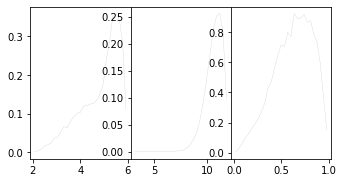

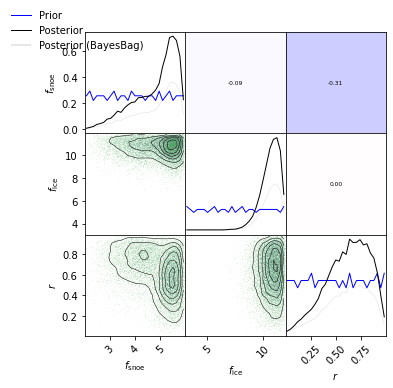

In [116]:
    X_std = X_P_std
    X_mean = X_P_mean
    frac = 1.0
    lw = 1
    color_prior = "b"
    X_list = []
    X_keys= ["f_snow", "f_ice", "refreeze"]
    X_Prior = (X_P_prior.detach().cpu().numpy() * X_P_std[-3::] .detach().cpu().numpy() + X_P_mean[-3::] .detach().cpu().numpy())
    keys_dict = {"f_ice": "$f_{\mathrm{ice}}$", "f_snow": "$f_{\mathrm{snoe}}$", "refreeze": "$r$"}
    p = Path(f"{emulator_dir}/posterior_samples/")
    print("Loading posterior samples\n")
    for m, m_file in enumerate(sorted(p.glob("X_posterior_model_*.csv.gz"))):
        print(f"  -- {m_file}")
        df = pd.read_csv(m_file).sample(frac=frac)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)
        model = m_file.name.split("_")[-1].split(".")[0]
        df["Model"] = int(model)
        X_list.append(df)

    print(f"Merging posteriors into dataframe")
    posterior_df = pd.concat(X_list)

    X_posterior = posterior_df.drop(columns=["Model"]).values
    C_0 = np.corrcoef((X_posterior - X_posterior.mean(axis=0)).T)
    Cn_0 = (np.sign(C_0) * C_0 ** 2 + 1) / 2.0

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5.4, 2.8))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    for i in range(3):
        min_val = min(X_Prior[:, i].min(), X_posterior[:, i].min())
        max_val = max(X_Prior[:, i].max(), X_posterior[:, i].max())
        bins = np.linspace(min_val, max_val, 30)
        X_prior_hist, b = np.histogram(X_Prior[:, i] , bins, density=True)
        X_posterior_hist, _ = np.histogram(X_posterior[:, i], bins, density=True)
        b = 0.5 * (b[1:] + b[:-1])
        axs[i].plot(
            b,
            X_posterior_hist * 0.5,
            color="0.5",
            linewidth=lw * 0.25,
            linestyle="solid",
            alpha=0.5,
        )

    figfile = f"{emulator_dir}/posterior.pdf"
    print(f"Saving figure to {figfile}")
    fig.savefig(figfile)

    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(5.4, 5.6))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    for i in range(3):
        for j in range(3):
            if i > j:

                axs[i, j].scatter(
                    X_posterior[:, j],
                    X_posterior[:, i],
                    c="#31a354",
                    s=0.05,
                    alpha=0.01,
                    label="Posterior",
                    rasterized=True,
                )

                min_val = min(X_Prior[:, i].min(), X_posterior[:, i].min())
                max_val = max(X_Prior[:, i].max(), X_posterior[:, i].max())
                bins_y = np.linspace(min_val, max_val, 30)

                min_val = min(X_Prior[:, j].min(), X_posterior[:, j].min())
                max_val = max(X_Prior[:, j].max(), X_posterior[:, j].max())
                bins_x = np.linspace(min_val, max_val, 30)

                v = gaussian_kde(X_posterior[:, [j, i]].T)
                bx = 0.5 * (bins_x[1:] + bins_x[:-1])
                by = 0.5 * (bins_y[1:] + bins_y[:-1])
                Bx, By = np.meshgrid(bx, by)

                axs[i, j].contour(
                    Bx,
                    By,
                    v(np.vstack((Bx.ravel(), By.ravel()))).reshape(Bx.shape),
                    7,
                    linewidths=0.5,
                    colors="black",
                )

                axs[i, j].set_xlim(X_Prior[:, j].min(), X_Prior[:, j].max())
                axs[i, j].set_ylim(X_Prior[:, i].min(), X_Prior[:, i].max())

            elif i < j:
                patch_upper = Polygon(
                    np.array([[0.0, 0.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0]]),
                    facecolor=plt.cm.seismic(Cn_0[i, j]),
                )
                axs[i, j].add_patch(patch_upper)
                if C_0[i, j] > -0.5:
                    color = "black"
                else:
                    color = "white"
                axs[i, j].text(
                    0.5,
                    0.5,
                    "{0:.2f}".format(C_0[i, j]),
                    fontsize=6,
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=axs[i, j].transAxes,
                    color=color,
                )

            elif i == j:
                min_val = min(X_Prior[:, i].min(), X_posterior[:, i].min())
                max_val = max(X_Prior[:, i].max(), X_posterior[:, i].max())
                bins = np.linspace(min_val, max_val, 30)
                X_prior_hist, b = np.histogram(X_Prior[:, i], bins, density=True)
                X_posterior_hist, _ = np.histogram(
                    X_posterior[:, i], bins, density=True
                )
                b = 0.5 * (b[1:] + b[:-1])

                axs[i, j].plot(
                    b,
                    X_prior_hist,
                    color=color_prior,
                    linewidth=lw,
                    label="Prior",
                    linestyle="solid",
                )

                all_models = posterior_df["Model"].unique()
                for k, m_model in enumerate(all_models):
                    m_df = posterior_df[posterior_df["Model"] == m_model].drop(
                        columns=["Model"]
                    )
                    X_model_posterior = m_df.values
                    X_model_posterior_hist, _ = np.histogram(
                        X_model_posterior[:, i], _, density=True
                    )
                    if k == 0:
                        axs[i, j].plot(
                            b,
                            X_model_posterior_hist * 0.5,
                            color="0.5",
                            linewidth=lw * 0.25,
                            linestyle="solid",
                            alpha=0.5,
                            label="Posterior (BayesBag)",
                        )
                    else:
                        axs[i, j].plot(
                            b,
                            X_model_posterior_hist * 0.5,
                            color="0.5",
                            linewidth=lw * 0.25,
                            linestyle="solid",
                            alpha=0.5,
                        )

                axs[i, j].plot(
                    b,
                    X_posterior_hist,
                    color="black",
                    linewidth=lw,
                    linestyle="solid",
                    label="Posterior",
                )

                axs[i, j].set_xlim(min_val, max_val)

            else:
                axs[i, j].remove()

    for i, ax in enumerate(axs[:, 0]):
        ax.set_ylabel(keys_dict[X_keys[i]])

    for j, ax in enumerate(axs[-1, :]):
        ax.set_xlabel(keys_dict[X_keys[j]])
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
        if j > 0:
            ax.tick_params(axis="y", which="both", length=0)
            ax.yaxis.set_minor_formatter(NullFormatter())
            ax.yaxis.set_major_formatter(NullFormatter())

    for ax in axs[:-1, 0].ravel():
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.tick_params(axis="x", which="both", length=0)

    for ax in axs[:-1, 1:].ravel():
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())
        ax.tick_params(axis="both", which="both", length=0)

    l_prior = Line2D([], [], c=color_prior, lw=lw, ls="solid", label="Prior")
    l_post = Line2D([], [], c="k", lw=lw, ls="solid", label="Posterior")
    l_post_b = Line2D(
        [], [], c="0.25", lw=lw * 0.25, ls="solid", label="Posterior (BayesBag)"
    )

    legend = fig.legend(
        handles=[l_prior, l_post, l_post_b], bbox_to_anchor=(0.3, 0.955)
    )
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)

    figfile = f"{emulator_dir}/emulator_posterior.pdf"
    print(f"Saving figure to {figfile}")
    fig.savefig(figfile)


In [ ]:
posterior_df.mean()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir lightning_logs/

In [ ]:
X_test

In [ ]:
" ".join([f"-{k} {d[k]}" for k in d])

In [ ]:
x = np.linspace(0, 1, 100)
a = torch.distributions.Binomial(total_count=9,probs=torch.tensor(x)).log_prob(torch.tensor([6])).exp()

In [ ]:
import pylab as plt
plt.plot(x, a)